# Imports et chargement des données

In [1]:
import os
import gc
from datetime import datetime
from importlib import reload  
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import json

from scipy.misc import derivative

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import fbeta_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import GridSearchCV

import lightgbm as lgbm
from lightgbm import LGBMClassifier


# mes modules
import kagfonct as kf

In [2]:
plt.rcParams.update({"font.size" : 12, 'axes.titleweight':"bold", 'axes.labelweight': 'bold', \
                     "figure.figsize":[10,8], "savefig.bbox":"tight"})


In [3]:
PATH = "./data/"
for fic in os.listdir(PATH):
    print(fic)
# print(os.listdir(path))   

application_test.csv
application_train.csv
bureau.csv
bureau_balance.csv
credit_card_balance.csv
HomeCredit_columns_description - Copy.csv
HomeCredit_columns_description - test.csv
HomeCredit_columns_description - utf8.csv
HomeCredit_columns_description.csv
HomeCredit_columns_description.ods
installments_payments.csv
POS_CASH_balance.csv
previous_application.csv
Projet+Mise+en+prod+-+home-credit-default-risk.zip
sample_submission.csv


In [4]:
df_application_test = pd.read_csv(PATH+"application_test.csv")
df_application_train = pd.read_csv(PATH+"application_train.csv")
df_bureau = pd.read_csv(PATH+"bureau.csv")
df_bureau_balance = pd.read_csv(PATH+"bureau_balance.csv")
df_credit_card_balance = pd.read_csv(PATH+"credit_card_balance.csv")
df_payments = pd.read_csv(PATH+"installments_payments.csv")
df_pos_cash_balance = pd.read_csv(PATH+"POS_CASH_balance.csv")
df_prev_app = pd.read_csv(PATH+"previous_application.csv")
# df_homecredit = pd.read_csv(PATH+"HomeCredit_columns_description - utf8.csv")
df_homecredit = pd.read_csv(PATH+"HomeCredit_columns_description.csv", encoding = "cp1252")

NB : le fichier "HomeCredit_columns_description.csv" comporte à plusieurs reprises, un caractère qui n'est pas dans la norme utf-8 (…)

In [5]:
df_homecredit.loc[12,"Description"]

'Clients income type (businessman, working, maternity leave,…)'

# Fonctions

## Fonctions liées à l'évaluation

In [6]:
def conf_matrix(y_true, y_pred, seuil, verbose=True): 
    """
    input :
    y_true : vecteur de la classification attendue (classification binaire)
    y_pred : score prédit
    seuil : seuil pour décider qu'un score est positif
    
    output :
    pour différents seuils :
    tn : vecteur des vrais négatifs
    fp : vecteur des faux positifs
    fn : vecteur des faux négatifs
    tp : vecteur des vrais positifs
    fpr : taux de faux positifs
    fnr : taux de faux négatifs
    precision
    recall
    
    """
#     fpr, tpr, th = roc_curve(y_true, y_pred)
    tp = []
    tn = []
    fn = []
    fp = []
    scores = []
    c_pred = (y_pred >= seuil).astype(int) #class prediction
    tp = ((c_pred==1) & (y_true==1)).sum()
    tn = ((c_pred==0) & (y_true==0)).sum()
    fn = ((c_pred==0) & (y_true==1)).sum()
    fp = ((c_pred==1) & (y_true==0)).sum()
    fpr = fp/(fp+tn)
    fnr = fn/(fn+tp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    if verbose :
        print("tp : ", tp)
        print("tn : ", tn)
        print("fp : ", fp)
        print("fn : ", fn)
        print(f"fpr = {fpr*100:.2f}%")
        print(f"fnr = {fnr*100:.2f}%")
        print(f"precision = {precision*100:.2f}%")
        print(f"recall = {recall*100:.2f}%")


    return tn, fp, fn, tp, fpr, fnr, precision, recall
    


In [7]:
def to_labels(preds, threshold):
    return (preds >= threshold).astype(int)

In [8]:
def matthews_eval(preds, train_data):
#     seuil = 0.5
    y_true = train_data.get_label()
#     c_pred = (preds >= seuil)
#     score = matthews_corrcoef(y_true, c_pred)
    thresholds = np.arange(0,1, 0.01)
    scores = [matthews_corrcoef(y_true, to_labels(preds, t)) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]
#     print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    
#     return eval_name, eval_result, is_higher_better    
    return "matthews_eval", score, True



In [9]:
# def fbeta_eval(preds, train_data):
#     beta = 0.5
#     seuil = 0.5
#     y_true = train_data.get_label()
#     c_pred = (preds >= seuil)
#     score = fbeta_score(y_true, c_pred, beta=beta)
#     return "fbeta_eval", score, True


In [10]:
def fbeta_eval2(preds, train_data):
    beta = 2
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval2", score, True


In [11]:
def fbeta_eval3(preds, train_data):
    beta = 3
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval3", score, True


In [12]:
def fbeta_eval3_8(preds, train_data):
    beta = 3.8
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval3_8", score, True


In [13]:
def fbeta_eval4(preds, train_data):
    beta = 4
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval4", score, True


In [14]:
def fbeta_eval0_5(preds, train_data):
    beta = 0.5
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval0_5", score, True


In [15]:
def eval_auc(preds, train_data):
    y_true = train_data.get_label()
    fpr, tpr, th = roc_curve(y_true, preds)
    score =  auc(fpr, tpr)
    return "eval_auc", score, True


In [16]:
def eval_average_precision(preds, train_data):
    y_true = train_data.get_label()
    score = average_precision_score(y_true, preds)
    return "eval_average_precision", score, True

In [17]:
def eval_balanced_accuracy_score(preds, train_data):
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [balanced_accuracy_score(y_true, to_labels(preds, t)) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]
    return "eval_balanced_accuracy_score", score, True    

In [18]:
def precision_recal_auc(preds, train_data):
#     print(preds.min(), preds.max())
    y_true = train_data.get_label()
    precision, recall, th = precision_recall_curve(y_true, preds)
    score = auc(recall, precision)
    return "precision_recal_auc", score, True

In [19]:
def eval_Kulczynski_mod(preds, train_data):
    lambd = 0.4
    y_true = train_data.get_label()
    scores = []
    
    for seuil in np.arange(0,1, 0.01):
        score = Kulczynski_mod_score(y_true, preds, seuil, lambd)
#         tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
#         score = lambd*precision + (1-lambd)*recall
        scores.append(score)
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    return "eval_Kulczynski_mod", score, True

In [20]:
def Kulczynski_mod_score(y_true, preds, seuil, lambd):
    tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
    score = lambd*precision + (1-lambd)*recall   
    return score

In [21]:
def eval_perso1(preds, train_data):
    lambd = 0.5
    mu = 0.5
    y_true = train_data.get_label()
    scores = []
    
    for seuil in np.arange(0,1, 0.001):
        score = perso1_score(y_true, preds, seuil, lambd, mu)
#         tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
#         score = tp/(lambd*tp + (1-lambd)*fp) + tp/(mu*tp + (1-mu)*fn)
        scores.append(score)
    idx = np.argmax(scores)
    score  = scores[idx]
    return "eval_perso1", score, True    

In [22]:
def perso1_score(y_true, preds, seuil, lambd, mu):
        tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
        score = tp/(lambd*tp + (1-lambd)*fp) + tp/(mu*tp + (1-mu)*fn)
        print(seuil, tn, fp, fn, tp, score)
        return score

In [23]:
def eval_tanimoto_mod(preds, train_data):
    y_true = train_data.get_label()
    scores = []
    for seuil in np.arange(0,1, 0.01):
        score = tanimoto_mod_score(y_true, preds, seuil)
        scores.append(score)
    idx = np.argmax(scores)
    score  = scores[idx]
    return "eval_tanimoto_mod", score, True    

In [24]:
def tanimoto_mod_score(y_true, preds, seuil):
#     print(y_true)
#     print(preds)
    tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
    score = (tp+tn) / (tp + 2*fp + 20*fn + tn)
#     print(seuil, tn, fp, fn, tp, score)
    return score

origine du code ci-dessous:  
https://towardsdatascience.com/lightgbm-with-the-focal-loss-for-imbalanced-datasets-9836a9ae00ca

In [25]:
def fl(pred, y_true, alpha, gamma):
    """
    focal loss pour une classification binaire
    pred : float : valeur prédite pour un élément
    y_true : float : valeur réelle pour cet élément
    alpha : coefficient de 'desequilibre'
    gamma : coefficient de 'puissance'
    """
    focal = alpha * y_true * (1-pred)**gamma * np.log(pred) +(1-y_true) * pred**gamma * np.log(1-pred)
    return  -focal


In [26]:
# def focal_loss_lgb(preds, train_data, alpha, gamma):
#     y_true = train_data.get_label()
#     print( "preds :" ,preds)
#     print("y_true :", y_true)

#     partial_fl = lambda x: fl(x, y_true, alpha, gamma)
#     grad = derivative(partial_fl, preds, n=1, dx=1e-6)
#     hess = derivative(partial_fl, preds, n=2, dx=1e-6)
#     print("grad : ", grad)
#     print("hess : ", hess)
#     return grad, hess

In [27]:
def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
    a,g = alpha, gamma
    y_true = dtrain.label
    
    def fl(x,t):
        p = 1/(1+np.exp(-x))
#         p = x
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
#         focal = a * t*((1-p)**g)*np.log(p) + (1-a)*(1-t)* (p**g) *np.log(1-p)
# #         print(-focal.min(), -focal.max())
#         return -focal
 
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess

In [28]:
def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma):
    a,g = alpha, gamma
    y_true = dtrain.label
#     p = y_pred
    p = 1/(1+np.exp(-y_pred))
    focal = a * y_true*((1-p)**g)*np.log(p) + (1-a)*(1-y_true)* (p**g) *np.log(1-p)
    
#   p = 1/(1+np.exp(-y_pred))
#   loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
  # (eval_name, eval_result, is_higher_better)
    return 'focal_loss', np.mean(-focal), False

In [29]:
def robust_pow(num_base, num_pow):
    # numpy does not permit negative numbers to fractional power
    # use this to perform the power algorithmic

    return np.sign(num_base) * (np.abs(num_base)) ** (num_pow)

def focal_binary_object(pred, dtrain):
    gamma_indct = 1.5
    # retrieve data from dtrain matrix
    label = dtrain.get_label()
    # compute the prediction with sigmoid
    sigmoid_pred = 1.0 / (1.0 + np.exp(-pred))
    # gradient
    # complex gradient with different parts
    g1 = sigmoid_pred * (1 - sigmoid_pred)
    g2 = label + ((-1) ** label) * sigmoid_pred
    g3 = sigmoid_pred + label - 1
    g4 = 1 - label - ((-1) ** label) * sigmoid_pred
    g5 = label + ((-1) ** label) * sigmoid_pred
    # combine the gradient
    grad = gamma_indct * g3 * robust_pow(g2, gamma_indct) * np.log(g4 + 1e-9) + \
           ((-1) ** label) * robust_pow(g5, (gamma_indct + 1))
    # combine the gradient parts to get hessian components
    hess_1 = robust_pow(g2, gamma_indct) + \
             gamma_indct * ((-1) ** label) * g3 * robust_pow(g2, (gamma_indct - 1))
    hess_2 = ((-1) ** label) * g3 * robust_pow(g2, gamma_indct) / g4
    # get the final 2nd order derivative
    hess = ((hess_1 * np.log(g4 + 1e-9) - hess_2) * gamma_indct +
            (gamma_indct + 1) * robust_pow(g5, gamma_indct)) * g1

    return grad, hess

## Autres fonctions

In [30]:
def unfactorize(df, indexers):
    """
    Opération inverse de factorize() : à partir des données de indexers, 
    transforme les valeurs numériques en variables catégorielles
    transformation "inplace"
    
    df: dataframe
    indexers : dictionnaire
        clé : colonne à transformer
        valeur : liste des valeurs, dans l'ordre correspondant au code donné
            ex : ["Homme", "Femme"] si "Homme" a le code 0 et "Femme" le code 1
    """
    
    for col in indexers.keys():
        conversion = indexers[col]
        new = df[col].apply(lambda x: conversion[x])
        df.update(new)
    return

# Exploration

In [31]:
df_application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [32]:
df_application_train.sample(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
36532,142313,1,Revolving loans,F,N,Y,1,137025.0,135000.0,6750.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
224624,360163,0,Cash loans,F,N,Y,0,90000.0,157500.0,11902.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
119038,238030,0,Cash loans,F,N,Y,1,270000.0,1133748.0,33277.5,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0
209700,343030,0,Cash loans,F,N,Y,1,85500.0,167076.0,12622.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
14110,116450,0,Cash loans,F,N,Y,1,171000.0,808650.0,26086.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
201219,333243,1,Cash loans,M,N,N,0,360000.0,855000.0,38637.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0
300298,447901,0,Cash loans,F,N,Y,0,157500.0,360000.0,28440.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,2.0
80615,193458,0,Cash loans,F,Y,Y,0,180000.0,1857735.0,64701.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
257956,398516,0,Cash loans,F,N,Y,1,202500.0,1288350.0,37800.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
260204,401127,0,Cash loans,F,N,Y,0,144000.0,497520.0,28692.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Nombre de colonnes ayant des valeurs nulles
(df_application_train.isnull().sum()>0).sum()

67

In [34]:
df_homecredit[df_homecredit["Table"]=="application_{train|test}.csv"]

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
117,120,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
118,121,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
119,122,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
120,123,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN


In [35]:
list(df_homecredit.loc[(df_homecredit["Table"]=="application_{train|test}.csv") & (df_homecredit["Row"]=="TARGET"), 
                       "Description"])

['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)']

In [36]:
list(df_application_train.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [37]:
df_application_test.sample(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
13738,199378,Cash loans,M,N,Y,0,315000.0,126000.0,NaN,126000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,6.0
20331,247655,Cash loans,F,N,N,0,144000.0,339948.0,34830.0,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
9479,169030,Cash loans,F,N,Y,2,135000.0,45000.0,4977.0,45000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
33250,342308,Cash loans,M,N,Y,0,360000.0,297040.5,23116.5,265500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
43523,417183,Cash loans,F,Y,Y,0,180000.0,450000.0,35554.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
5754,142167,Cash loans,M,Y,N,0,112500.0,654048.0,24786.0,540000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
23704,272405,Cash loans,F,Y,N,0,135000.0,203301.0,17577.0,175500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
35288,358231,Cash loans,F,Y,Y,0,67500.0,567000.0,29079.0,567000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
2186,115405,Cash loans,M,Y,Y,0,261000.0,675000.0,53329.5,675000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1926,113585,Cash loans,M,N,Y,0,202500.0,781920.0,34573.5,675000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df_bureau.sample(10)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
439932,334348,5942905,Active,currency 1,-372,0,1454.0,NaN,NaN,0,1125000.00,985761.000,0.000,0.0,Consumer credit,-8,0.0
690803,295129,5317612,Active,currency 1,-228,0,NaN,NaN,0.0,0,132425.37,96291.000,36131.355,0.0,Credit card,-12,0.0
1593704,100183,5593923,Active,currency 1,-1477,0,-1143.0,-1477.0,0.0,0,61027.11,0.000,0.000,0.0,Consumer credit,-1249,NaN
169538,116667,6369252,Active,currency 1,-247,0,484.0,NaN,NaN,0,113359.50,82715.175,NaN,0.0,Consumer credit,-10,NaN
1365791,360634,5415748,Closed,currency 1,-568,0,-387.0,-387.0,0.0,0,392400.00,0.000,0.000,0.0,Consumer credit,-386,NaN
1472735,291181,6741776,Active,currency 1,-916,0,NaN,NaN,0.0,0,225000.00,183757.500,720.000,0.0,Credit card,-7,4500.0
1046356,297917,6434705,Active,currency 1,-708,0,NaN,NaN,0.0,0,270000.00,232272.000,37723.860,0.0,Credit card,-16,27000.0
368712,252918,5518183,Closed,currency 1,-1601,0,-1235.0,-1234.0,NaN,0,31905.00,0.000,0.000,0.0,Consumer credit,-978,0.0
88492,127987,5616547,Closed,currency 1,-2650,0,-2345.0,-2375.0,0.0,0,35968.50,0.000,0.000,0.0,Consumer credit,-2369,NaN
44242,357505,5214831,Active,currency 1,-324,0,1013.0,NaN,NaN,0,135000.00,127863.000,0.000,0.0,Credit card,-38,NaN


In [39]:
# Nombre de colonnes ayant des valeurs nulles
(df_bureau.isnull().sum()>0).sum()

7

In [40]:
df_bureau[df_bureau["SK_ID_CURR"]==368092]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
514934,368092,6457783,Closed,currency 1,-487,0,-122.0,-121.0,NaN,0,114750.0,0.0,0.0,0.0,Consumer credit,-116,0.0
514935,368092,6457784,Closed,currency 1,-1676,0,-580.0,-1505.0,NaN,0,270000.0,0.0,0.0,0.0,Consumer credit,-1423,5044.5
514936,368092,6457785,Closed,currency 1,-1676,0,-580.0,-610.0,NaN,0,270000.0,0.0,0.0,0.0,Consumer credit,-339,0.0
514937,368092,6457786,Closed,currency 1,-1819,0,-1547.0,-1197.0,NaN,0,83385.0,NaN,NaN,0.0,Consumer credit,-1194,0.0


In [41]:
df_bureau_balance[df_bureau_balance["SK_ID_BUREAU"]== 6457783]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
10396161,6457783,0,C
10396162,6457783,-1,C
10396163,6457783,-2,C
10396164,6457783,-3,C
10396165,6457783,-4,C
10396166,6457783,-5,0
10396167,6457783,-6,0
10396168,6457783,-7,0
10396169,6457783,-8,X
10396170,6457783,-9,0


In [42]:
df_bureau_balance["STATUS"].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [43]:
# Nombre de colonnes ayant des valeurs nulles
(df_bureau_balance.isnull().sum()>0).sum()

0

In [44]:
df_homecredit[df_homecredit["Table"]=="bureau_balance.csv"]

,Unnamed: 0,Table,Row,Description,Special
139,142,bureau_balance.csv,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...,hashed
140,143,bureau_balance.csv,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
141,144,bureau_balance.csv,STATUS,Status of Credit Bureau loan during the month ...,NaN


In [45]:
df_pos_cash_balance[df_pos_cash_balance["SK_ID_CURR"]==368092].sort_values(by="MONTHS_BALANCE")

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
9535021,2198792,368092,-82,12.0,12.0,Active,0,0
948279,2198792,368092,-81,12.0,11.0,Active,0,0
9001077,2198792,368092,-80,12.0,10.0,Active,0,0
6410934,2198792,368092,-79,12.0,9.0,Active,0,0
4157178,2198792,368092,-78,12.0,8.0,Active,0,0
4097603,2198792,368092,-77,12.0,7.0,Active,0,0
1377294,2198792,368092,-76,12.0,6.0,Active,0,0
2462432,2198792,368092,-75,12.0,5.0,Active,0,0
3171983,2198792,368092,-74,12.0,4.0,Active,0,0
3216998,2198792,368092,-73,12.0,3.0,Active,0,0


In [46]:
# Nombre de colonnes ayant des valeurs nulles
(df_pos_cash_balance.isnull().sum()>0).sum()

2

In [47]:
df_homecredit[df_homecredit["Table"]=="POS_CASH_balance.csv"]

,Unnamed: 0,Table,Row,Description,Special
142,145,POS_CASH_balance.csv,SK_ID_PREV,ID of previous credit in Home Credit related t...,NaN
143,146,POS_CASH_balance.csv,SK_ID_CURR,ID of loan in our sample,NaN
144,147,POS_CASH_balance.csv,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN
146,149,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN
147,150,POS_CASH_balance.csv,NAME_CONTRACT_STATUS,Contract status during the month,NaN
148,151,POS_CASH_balance.csv,SK_DPD,DPD (days past due) during the month of previo...,NaN
149,152,POS_CASH_balance.csv,SK_DPD_DEF,DPD during the month with tolerance (debts wit...,NaN


In [48]:
df_credit_card_balance.sample(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
3212400,2208117,453580,-34,0.000,180000,0.0,0.00,0.0,0.00,0.00,...,0.000,0.000,0.0,0,0.0,0.0,28.0,Active,0,0
3556169,2573180,342449,-56,158318.640,180000,0.0,0.00,0.0,0.00,9000.00,...,157458.195,157458.195,0.0,0,0.0,0.0,33.0,Active,0,0
1589234,1660894,208350,-48,86891.940,112500,0.0,0.00,0.0,0.00,5625.00,...,86891.940,86891.940,0.0,0,0.0,0.0,45.0,Active,0,0
295741,1237871,336377,-30,166318.155,225000,0.0,30519.09,0.0,30519.09,6965.28,...,166318.155,166318.155,0.0,12,0.0,12.0,6.0,Active,0,0
3754575,1211176,141710,-28,0.000,0,0.0,0.00,0.0,0.00,0.00,...,0.000,0.000,0.0,0,0.0,0.0,17.0,Active,0,0
2002890,1925824,107368,-5,0.000,45000,0.0,0.00,0.0,0.00,0.00,...,0.000,0.000,0.0,0,0.0,0.0,24.0,Active,0,0
195350,2445998,307485,-12,0.000,180000,0.0,0.00,0.0,0.00,0.00,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3438068,1233007,296183,-14,0.000,270000,NaN,0.00,NaN,NaN,0.00,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
2872276,2173290,181574,-32,0.000,157500,0.0,0.00,0.0,0.00,0.00,...,0.000,0.000,0.0,0,0.0,0.0,55.0,Active,0,0
1454510,2116652,167083,-28,0.000,0,0.0,0.00,0.0,0.00,0.00,...,0.000,0.000,0.0,0,0.0,0.0,11.0,Active,0,0


In [49]:
# Nombre de colonnes ayant des valeurs nulles
(df_credit_card_balance.isnull().sum()>0).sum()

9

In [50]:
df_prev_app.sample(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1466524,2013699,444060,Cash loans,34220.385,180000.000,185940.0,NaN,180000.000,WEDNESDAY,13,...,XNA,6.0,middle,Cash X-Sell: middle,365243.0,-574.0,-424.0,-424.0,-418.0,1.0
251706,2336052,361510,Consumer loans,15338.475,125955.000,136885.5,12595.500,125955.000,SUNDAY,14,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1710.0,-1440.0,-1440.0,-1433.0,0.0
253858,1472945,238065,Cash loans,NaN,0.000,0.0,NaN,NaN,THURSDAY,12,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1483118,1755258,374265,Revolving loans,NaN,0.000,0.0,NaN,NaN,TUESDAY,18,...,XNA,NaN,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
1188170,2036957,302565,Revolving loans,NaN,0.000,0.0,NaN,NaN,TUESDAY,13,...,XNA,NaN,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
863234,1173491,181530,Consumer loans,14111.505,151150.500,148824.0,22675.500,151150.500,SATURDAY,13,...,Connectivity,18.0,high,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
166060,2462908,139299,Consumer loans,13449.150,134509.095,121054.5,13454.595,134509.095,FRIDAY,12,...,Consumer electronics,10.0,low_normal,POS household without interest,365243.0,-2517.0,-2247.0,-2247.0,-2238.0,0.0
101837,2261216,424078,Consumer loans,9167.445,107982.000,97182.0,10800.000,107982.000,SATURDAY,14,...,Consumer electronics,18.0,high,POS household with interest,365243.0,-406.0,104.0,-226.0,-219.0,0.0
426763,2376550,235409,Consumer loans,NaN,66960.000,66960.0,0.000,66960.000,THURSDAY,13,...,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
103321,1102669,115551,Cash loans,9139.005,85500.000,108562.5,NaN,85500.000,THURSDAY,12,...,XNA,18.0,high,Cash X-Sell: high,365243.0,-397.0,113.0,-397.0,-389.0,1.0


In [51]:
# Nombre de colonnes ayant des valeurs nulles
(df_prev_app.isnull().sum()>0).sum()

16

In [52]:
df_prev_app[df_prev_app["SK_ID_CURR"]==368092]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
132593,2198792,368092,Consumer loans,5921.37,122764.14,60732.0,67504.14,122764.14,MONDAY,13,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2475.0,-2145.0,-2145.0,-2136.0,1.0


In [53]:
df_payments.sample(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
5512748,2836517,224069,0.0,32,-1812.0,-1820.0,9000.000,9000.000
11262330,1096238,343392,5.0,6,-235.0,-247.0,62812.890,62812.890
6087650,2087036,268287,1.0,2,-604.0,-615.0,3020.985,3020.985
8063048,2759757,311761,1.0,8,-830.0,-831.0,19735.245,19735.245
8494137,1625171,361590,1.0,8,-1357.0,-1364.0,17601.075,17601.075
10984687,2727183,318987,0.0,52,-398.0,-398.0,2160.000,2160.000
3087032,2119965,155680,1.0,7,-1576.0,-1603.0,7893.675,7893.675
6283959,1640071,222682,2.0,21,-112.0,-139.0,66867.435,66867.435
9818752,1209415,314307,1.0,2,-788.0,-799.0,5266.125,5266.125
9471825,2518275,332898,1.0,6,-787.0,-787.0,17941.725,17941.725


In [54]:
# Nombre de colonnes ayant des valeurs nulles
(df_payments.isnull().sum()>0).sum()

2

In [55]:
df_payments[df_payments["SK_ID_CURR"]==368092].sort_values(by="NUM_INSTALMENT_NUMBER")

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
8624343,2198792,368092,1.0,1,-2475.0,-2485.0,5921.37,5921.37
8085854,2198792,368092,1.0,2,-2445.0,-2447.0,5921.37,5921.37
9254042,2198792,368092,1.0,3,-2415.0,-2419.0,5921.37,5921.37
7829329,2198792,368092,1.0,4,-2385.0,-2387.0,5921.37,5921.37
9254285,2198792,368092,1.0,5,-2355.0,-2358.0,5921.37,5921.37
10778313,2198792,368092,1.0,6,-2325.0,-2344.0,5921.37,5921.37
9235293,2198792,368092,1.0,7,-2295.0,-2296.0,5921.37,5921.37
8320158,2198792,368092,1.0,8,-2265.0,-2274.0,5921.37,5921.37
11155326,2198792,368092,1.0,9,-2235.0,-2246.0,5921.37,5921.37
11034595,2198792,368092,1.0,10,-2205.0,-2204.0,5921.37,5921.37


# Feature Engineering

## Intégration des données

In [56]:
reload(kf)

<module 'kagfonct' from 'D:\\Laure\\AnacondaProjects\\20 - openclassrooms\\10 - parcoursDS\\7 - Scoring\\modelisation\\kagfonct.py'>

In [57]:
data, y, indexers = kf.build_model_input(PATH)

Buro bal shape :  (27299925, 3)
transform to dummies
Counting buros
averaging buro bal
Read Bureau
Go to dummies
Merge with buro avg
Counting buro per SK_ID_CURR
Averaging bureau
            SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
SK_ID_CURR                                                  
100001               7.0  -735.000000                 0.0   
100002               8.0  -874.000000                 0.0   
100003               4.0 -1400.750000                 0.0   
100004               2.0  -867.000000                 0.0   
100005               3.0  -190.666667                 0.0   

            DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
SK_ID_CURR                                                                   
100001                82.428571        -825.500000                     NaN   
100002              -349.000000        -697.500000                1681.029   
100003              -544.500000       -1097.333333                   0.000   
100

Go to dummies
Compute nb of prevs per curr
Go to averages
Reading CC balance
Go to dummies
Compute average
Reading Installments
Read data
Shapes :  (307511, 122)


In [58]:
indexers

{'NAME_CONTRACT_TYPE': Index(['Cash loans', 'Revolving loans'], dtype='object'),
 'CODE_GENDER': Index(['M', 'F', 'XNA'], dtype='object'),
 'FLAG_OWN_CAR': Index(['N', 'Y'], dtype='object'),
 'FLAG_OWN_REALTY': Index(['Y', 'N'], dtype='object'),
 'NAME_TYPE_SUITE': Index(['Unaccompanied', 'Family', 'Spouse, partner', 'Children', 'Other_A',
        'Other_B', 'Group of people'],
       dtype='object'),
 'NAME_INCOME_TYPE': Index(['Working', 'State servant', 'Commercial associate', 'Pensioner',
        'Unemployed', 'Student', 'Businessman', 'Maternity leave'],
       dtype='object'),
 'NAME_EDUCATION_TYPE': Index(['Secondary / secondary special', 'Higher education',
        'Incomplete higher', 'Lower secondary', 'Academic degree'],
       dtype='object'),
 'NAME_FAMILY_STATUS': Index(['Single / not married', 'Married', 'Civil marriage', 'Widow',
        'Separated', 'Unknown'],
       dtype='object'),
 'NAME_HOUSING_TYPE': Index(['House / apartment', 'Rented apartment', 'With parents',

In [59]:
# suppression des colonnes qui sont en fait des indexes
applicants = data["SK_ID_CURR"]
data.drop(columns = [x for x in list(data.columns) if 'SK_ID' in x], inplace=True)

In [60]:
#data.loc[data["DAYS_EMPLOYED"]>0, "DAYS_EMPLOYED"] = np.nan

In [61]:
df_data_true = pd.concat([pd.Series(y, name="risk"), data], axis=1)
df_data_true

,risk,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,1,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,0,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,0,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,0,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,0,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,NaN,NaN,NaN,NaN,1.142857,4.000000,-120.000000,-156.285714,7492.924286,7492.924286
307507,0,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500
307508,0,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,NaN,NaN,NaN,NaN,1.000000,4.785714,-2372.928571,-2387.428571,4399.707857,4115.915357
307509,1,0,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,NaN,NaN,NaN,NaN,1.000000,5.263158,-142.263158,-161.263158,10239.832895,10239.832895


## Analyse du résultat

In [62]:
print("taille des données : ", data.shape)
print("taille des prévisions : ", y.shape)

taille des données :  (307511, 374)
taille des prévisions :  (307511,)


In [63]:
y.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [64]:
print(f"pourcentage de personnes ayant des difficultés de paiement : {(y==1).sum()/len(y)*100:.1f}%")

pourcentage de personnes ayant des difficultés de paiement : 8.1%


In [65]:
data.sample(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
82327,0,0,1,0,0,225000.0,900000.0,26446.5,900000.0,0,...,NaN,NaN,NaN,NaN,1.000000,3.714286,-352.571429,-365.714286,3605.760000,3090.651429
286932,0,1,0,1,0,157500.0,1528200.0,53248.5,1350000.0,0,...,0.0,0.0,0.0,0.0,0.000000,65.489796,-1501.275510,-1501.795918,183.200969,183.200969
92347,0,1,0,0,0,54000.0,270000.0,14787.0,270000.0,0,...,NaN,NaN,NaN,NaN,1.000000,6.400000,-1522.920000,-1527.760000,22125.186000,19646.737200
86138,0,0,0,0,0,153000.0,545040.0,26640.0,450000.0,0,...,NaN,NaN,NaN,NaN,1.000000,6.807692,-781.076923,-788.423077,6802.836923,6207.424615
286708,0,1,0,1,0,90000.0,552555.0,30105.0,477000.0,0,...,NaN,NaN,NaN,NaN,1.000000,4.333333,-798.000000,-800.380952,11099.633571,11099.633571
24573,0,1,0,0,0,112500.0,1422000.0,37642.5,1422000.0,0,...,NaN,NaN,NaN,NaN,1.090909,11.121212,-527.393939,-538.333333,61053.512727,61053.512727
167440,0,1,0,0,1,202500.0,700830.0,22738.5,585000.0,1,...,0.0,0.0,0.0,0.0,0.666667,6.979167,-800.958333,-822.729167,22419.996562,22419.996562
31814,0,1,1,0,0,90000.0,127350.0,12726.0,112500.0,0,...,NaN,NaN,NaN,NaN,1.607143,7.357143,-816.285714,-830.250000,6660.253929,6157.215000
29577,0,0,0,0,2,67500.0,247500.0,12766.5,247500.0,2,...,NaN,NaN,NaN,NaN,1.111111,3.000000,-1046.333333,-1062.444444,17643.885000,17643.885000
159352,0,1,0,0,1,135000.0,1350000.0,50031.0,1350000.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Valeurs nulles

Pour le traitement des valeurs nulles, nous devons tenir compte du fait que le taux de personnes ayant des difficultés de paiement est de 8%. Il ne faut donc pas supprimer trop rapidement des valeurs qui pourraient être significatives pour ces personnes.

In [66]:
data.isnull().sum().sort_values(ascending=False)

RATE_INTEREST_PRIVILEGED           302902
RATE_INTEREST_PRIMARY              302902
cc_bal_AMT_PAYMENT_CURRENT         246451
cc_bal_AMT_DRAWINGS_ATM_CURRENT    246371
cc_bal_CNT_DRAWINGS_POS_CURRENT    246371
                                    ...  
REG_CITY_NOT_WORK_CITY                  0
HOUSETYPE_MODE                          0
LIVE_REGION_NOT_WORK_REGION             0
REG_REGION_NOT_WORK_REGION              0
NAME_CONTRACT_TYPE                      0
Length: 374, dtype: int64

In [67]:
# Nombre de colonnes ayant des valeurs nulles
(data.isnull().sum()>0).value_counts()

True     316
False     58
dtype: int64

In [68]:
# Nombre de lignes ayant des valeurs nulles
(data.isnull().sum(axis=1)>0).value_counts()

True     307494
False        17
dtype: int64

In [69]:
# Nombre de colonnes ayant moins de 1% de valeurs nulles
((data.isnull().sum()/data.count()*100)<1).value_counts()

False    307
True      67
dtype: int64

In [70]:
data.describe()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,...,86905.000000,86905.000000,86905.000000,86905.000000,291643.000000,291643.000000,291643.000000,291635.000000,2.916430e+05,2.916350e+05
mean,0.095213,0.658370,0.340108,0.306327,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.277512,...,0.000106,0.000002,0.000064,0.003738,1.041501,9.764795,-909.662335,-920.961181,1.839261e+04,1.875431e+04
std,0.293509,0.474284,0.473746,0.460968,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.722458,...,0.008740,0.000155,0.000877,0.031882,0.602107,11.273675,598.461681,597.024650,2.333797e+04,2.510536e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2922.000000,-3071.000000,0.000000e+00,1.890000e-01
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,4.555556,-1301.959806,-1311.842195,7.799513e+03,7.478370e+03
50%,0.000000,1.000000,0.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.017241,6.045455,-795.953488,-807.581818,1.257265e+04,1.222576e+04
75%,0.000000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.111111,9.434413,-419.000000,-431.609963,2.137614e+04,2.135286e+04
max,1.000000,2.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,6.000000,...,0.915789,0.013889,0.024390,1.000000,39.000000,138.110063,-3.000000,-3.000000,2.504590e+06,2.504590e+06


In [71]:
data.mean()

NAME_CONTRACT_TYPE                0.095213
CODE_GENDER                       0.658370
FLAG_OWN_CAR                      0.340108
FLAG_OWN_REALTY                   0.306327
CNT_CHILDREN                      0.417052
                                  ...     
inst_NUM_INSTALMENT_NUMBER        9.764795
inst_DAYS_INSTALMENT           -909.662335
inst_DAYS_ENTRY_PAYMENT        -920.961181
inst_AMT_INSTALMENT           18392.611499
inst_AMT_PAYMENT              18754.310245
Length: 374, dtype: float64

Pour les classifiers n'acceptant pas les valeurs nulles, nous les remplaceront par la moyenne.  
Ce n'est pas le cas de LGBM Classifier.

# Prévisions

In [72]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42)

In [73]:
print("tail X_train : ", X_train.shape)
print("taille X_test :" , X_test.shape)

tail X_train :  (206032, 374)
taille X_test : (101479, 374)


In [74]:
list(df_homecredit.loc[df_homecredit["Row"]=="TARGET", "Description"])

['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)']

Document sur les indices de similarité :  
http://iramuteq.org/documentation/detail-des-indices-de-similitude

## LGBMClassifier

In [75]:
eval_fonct = precision_recal_auc
# eval_fonct = lambda x,y: focal_loss_lgb_eval_error(x, y, alpha=0.25, gamma=2)
eval_fonct_score = precision_recal_auc
eval_fonct_str = "precision_recal_auc"
eval_fonct_param1 = 0
eval_fonct_param2 = 0
# obj_fonct = lambda x,y: focal_loss_lgb(x, y, alpha=0.75, gamma=1.5)

In [76]:
# focal_loss = lambda x,y: focal_loss_lgb(x, y, alpha=0.25, gamma=1.)
# focal_loss_eval = lambda x,y: focal_loss_lgb_eval_error(x, y, alpha=0.25, gamma=1.)
# model = lgb.train(best, self.lgtrain, fobj=focal_loss, feval=focal_loss_eval)

In [77]:
%%time

res = pd.DataFrame(columns=["a", "g", "round", "metric"])
# for a in [0.25, 0.5, 0.75]:
#     for g in [0.5,1,1.5, 2]:
for a in [0.75]:
    for g in [0.5]:
        obj_fonct = lambda x,y: focal_loss_lgb(x, y, alpha=a, gamma=g)
#         obj_fonct = focal_binary_object
        print(f"Heure de début : {str(datetime.now())}")

        lgbm_train = lgbm.Dataset(data=X_train,
                                  label=y_train,
        #                           categorical_feature=categorical_feats,
        #                          free_raw_data=False
                                 )
        lgbm_valid = lgbm.Dataset(data=X_test,
                                  label=y_test,
                                 )


        lgbm_params = {
            'boosting': 'dart',
            'application': 'binary',
            'objective':'binary',
            'learning_rate': 0.1,
            'min_data_in_leaf': 30,
            'num_leaves': 31,
            'max_depth': -1,
            'feature_fraction': 0.5,
            'scale_pos_weight': 1.4,
            'drop_rate': 0.025,
            # 'metrics': 'auc',
            # 'class_weight': 'balanced',
            # 'is_unbalance': True,
            'reg_lambda' : 14,
            'sigmoid' : 0.3
        }

        cv_results = lgbm.cv(train_set=lgbm_train,
                     params=lgbm_params,
                     nfold=5,
                     num_boost_round=1000,
        #                          early_stopping_rounds=100,
                     verbose_eval=50,
                     feval = eval_fonct,
                     fobj = obj_fonct
        #              metrics=['auc']
                            )

        optimum_boost_rounds = np.argmax(cv_results[eval_fonct_str +'-mean'][1:])
        print(f"parameters = alpha : {a}, gamma = {g}")
        print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
        best = np.max(cv_results[eval_fonct_str + '-mean'][1:])
        print('Best CV result = {}'.format(best))
        res.loc[len(res)]=[a, g, optimum_boost_rounds, best]



Heure de début : 2020-05-04 19:19:00.515159
[50]	cv_agg's precision_recal_auc: 0.253244 + 0.00709685
[100]	cv_agg's precision_recal_auc: 0.262326 + 0.0075496
[150]	cv_agg's precision_recal_auc: 0.2655 + 0.00762175
[200]	cv_agg's precision_recal_auc: 0.268119 + 0.00764601
[250]	cv_agg's precision_recal_auc: 0.270153 + 0.00777458
[300]	cv_agg's precision_recal_auc: 0.271822 + 0.00784931
[350]	cv_agg's precision_recal_auc: 0.272439 + 0.0076232
[400]	cv_agg's precision_recal_auc: 0.272829 + 0.00789089
[450]	cv_agg's precision_recal_auc: 0.27286 + 0.00743885
[500]	cv_agg's precision_recal_auc: 0.273081 + 0.00759543
[550]	cv_agg's precision_recal_auc: 0.27357 + 0.00754116
[600]	cv_agg's precision_recal_auc: 0.273634 + 0.00727834
[650]	cv_agg's precision_recal_auc: 0.273473 + 0.00772205
[700]	cv_agg's precision_recal_auc: 0.273381 + 0.0075826
[750]	cv_agg's precision_recal_auc: 0.273626 + 0.00750465
[800]	cv_agg's precision_recal_auc: 0.272897 + 0.00777036
[850]	cv_agg's precision_recal_auc: 

In [78]:
idx = res.loc[res["metric"] == max(res["metric"])].index[0]
alpha = res.loc[idx, "a"]
gamma = res.loc[idx, "g"]
optimum_boost_rounds = int(res.loc[idx, "round"])
print("alpha : ", alpha)
print("gamma : ", gamma)
print("round : ", optimum_boost_rounds)
print("meilleure performance : ", res.loc[idx, "metric"])
obj_fonct = lambda x,y: focal_loss_lgb(x, y, alpha=alpha, gamma=gamma)

alpha :  0.75
gamma :  0.5
round :  589
meilleure performance :  0.27387236939772375


In [79]:
test = np.array([.02, 0.3, 0.55, 0.82, 0.91, 0.96, .98])
rep = np.where(test>.95)
rep

(array([5, 6], dtype=int64),)

In [80]:
rep[0][0]

5

In [81]:
# optimum_boost_rounds = np.argmax(cv_results[eval_fonct_str +'-mean'])
# print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
# print('Best CV result = {}'.format(np.max(cv_results[eval_fonct_str + '-mean'])))

# # optimum_boost_rounds = np.argmin(cv_results[eval_fonct_str +'-mean'])
# # print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
# # print('Best CV result = {}'.format(np.min(cv_results[eval_fonct_str + '-mean'])))


**Résultats avec is_unbalance**  
lgbm_params = {
'boosting': 'dart',
'application': 'binary',
'learning_rate': 0.1,
'min_data_in_leaf': 30,
'num_leaves': 31,
'max_depth': -1,
'feature_fraction': 0.5,
'drop_rate': 0.025,
'metrics': 'auc',
'is_unbalance': True,
'reg_lambda' : 14,
'sigmoid' : 0.3
}

cv_results = lgbm.cv(train_set=lgbm_train,
             params=lgbm_params,
             nfold=5,
             num_boost_round=1000,
                          early_stopping_rounds=100,
             verbose_eval=100,
             metrics=['auc']
                    )  
                    
                    
[100]	cv_agg's auc: 0.77114 + 0.00260605
[200]	cv_agg's auc: 0.775329 + 0.00277529
[300]	cv_agg's auc: 0.777824 + 0.00282435
[400]	cv_agg's auc: 0.778755 + 0.00272432
[500]	cv_agg's auc: 0.779349 + 0.00250999
[600]	cv_agg's auc: 0.779549 + 0.00266121
[700]	cv_agg's auc: 0.779461 + 0.00267353
[800]	cv_agg's auc: 0.779466 + 0.00278914
[900]	cv_agg's auc: 0.779542 + 0.00284277
[1000]	cv_agg's auc: 0.779671 + 0.0028612
Optimum boost rounds = 986
Best CV result = 0.7797494433087251
Wall time: 3min 52s



**Variations de scale_pos_weight**  
for scale in np.linspace (1.2, 3, 10) : 
    lgbm_params = {
    'boosting': 'dart',
    'application': 'binary',
    'learning_rate': 0.1,
    'min_data_in_leaf': 30,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.5,
    'scale_pos_weight': scale,
    'drop_rate': 0.025,
    'metrics': 'auc',
    'class_weight': 'balanced',
    # 'is_unbalance': True,
    'reg_lambda' : 14,
    'sigmoid' : 0.3
    }

    cv_results = lgbm.cv(train_set=lgbm_train,
                 params=lgbm_params,
                 nfold=5,
                 num_boost_round=1000,
    #                          early_stopping_rounds=100,
                 verbose_eval=100,
                 metrics=['auc']
                        )

    optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
    print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
    print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))



Heure de début : 2020-04-14 11:28:15.187012
[100]	cv_agg's auc: 0.769767 + 0.00331941
[200]	cv_agg's auc: 0.772935 + 0.00344862
[300]	cv_agg's auc: 0.776687 + 0.00298045
[400]	cv_agg's auc: 0.778792 + 0.00286058
[500]	cv_agg's auc: 0.779526 + 0.00280973
[600]	cv_agg's auc: 0.780214 + 0.00291006
[700]	cv_agg's auc: 0.780316 + 0.00284064
[800]	cv_agg's auc: 0.780514 + 0.0027343
[900]	cv_agg's auc: 0.7805 + 0.00281825
[1000]	cv_agg's auc: 0.78041 + 0.00272825
Optimum boost rounds = 890
Best CV result = 0.7805579579825707
[100]	cv_agg's auc: 0.770749 + 0.00309585
[200]	cv_agg's auc: 0.774063 + 0.00338265
[300]	cv_agg's auc: 0.77736 + 0.00318675
[400]	cv_agg's auc: 0.778914 + 0.00310343
[500]	cv_agg's auc: 0.780063 + 0.00299021
[600]	cv_agg's auc: 0.780653 + 0.00293378
[700]	cv_agg's auc: 0.780839 + 0.00292982
[800]	cv_agg's auc: 0.780943 + 0.0030801
[900]	cv_agg's auc: 0.781118 + 0.0031577
[1000]	cv_agg's auc: 0.781108 + 0.00309517
Optimum boost rounds = 893
Best CV result = 0.7811757397112599
[100]	cv_agg's auc: 0.770534 + 0.00325684
[200]	cv_agg's auc: 0.773746 + 0.0030433
[300]	cv_agg's auc: 0.77694 + 0.00295683
[400]	cv_agg's auc: 0.778846 + 0.0025315
[500]	cv_agg's auc: 0.779553 + 0.00274158
[600]	cv_agg's auc: 0.780163 + 0.00259661
[700]	cv_agg's auc: 0.780464 + 0.00288203
[800]	cv_agg's auc: 0.780712 + 0.00309403
[900]	cv_agg's auc: 0.780745 + 0.0032112
[1000]	cv_agg's auc: 0.780769 + 0.00328433
Optimum boost rounds = 920
Best CV result = 0.7808296303070719
[100]	cv_agg's auc: 0.770662 + 0.00326064
[200]	cv_agg's auc: 0.77399 + 0.00316988
[300]	cv_agg's auc: 0.77717 + 0.00276563
[400]	cv_agg's auc: 0.77901 + 0.00273257
[500]	cv_agg's auc: 0.779651 + 0.00271691
[600]	cv_agg's auc: 0.780188 + 0.00288543
[700]	cv_agg's auc: 0.780462 + 0.00318229
[800]	cv_agg's auc: 0.780652 + 0.00322722
[900]	cv_agg's auc: 0.780585 + 0.00312511
[1000]	cv_agg's auc: 0.78059 + 0.00296092
Optimum boost rounds = 736
Best CV result = 0.780660218163799
[100]	cv_agg's auc: 0.771207 + 0.00286242
[200]	cv_agg's auc: 0.774668 + 0.00295244
[300]	cv_agg's auc: 0.777666 + 0.00266178
[400]	cv_agg's auc: 0.779503 + 0.00258824
[500]	cv_agg's auc: 0.779895 + 0.00294537
[600]	cv_agg's auc: 0.780533 + 0.00283984
[700]	cv_agg's auc: 0.780682 + 0.00294499
[800]	cv_agg's auc: 0.780604 + 0.00287269
[900]	cv_agg's auc: 0.780892 + 0.00285883
[1000]	cv_agg's auc: 0.780837 + 0.00294008
Optimum boost rounds = 892
Best CV result = 0.7808987781422839
[100]	cv_agg's auc: 0.771367 + 0.00288915
[200]	cv_agg's auc: 0.774619 + 0.00284786
[300]	cv_agg's auc: 0.777614 + 0.00283446
[400]	cv_agg's auc: 0.779433 + 0.00272813
[500]	cv_agg's auc: 0.779754 + 0.0027423
[600]	cv_agg's auc: 0.779998 + 0.00313448
[700]	cv_agg's auc: 0.780298 + 0.00312195
[800]	cv_agg's auc: 0.780431 + 0.00320818
[900]	cv_agg's auc: 0.780597 + 0.00327776
[1000]	cv_agg's auc: 0.78051 + 0.00335146
Optimum boost rounds = 852
Best CV result = 0.7806490864580116
[100]	cv_agg's auc: 0.77128 + 0.00269848
[200]	cv_agg's auc: 0.774866 + 0.00287929
[300]	cv_agg's auc: 0.777804 + 0.00274996
[400]	cv_agg's auc: 0.779104 + 0.00274491
[500]	cv_agg's auc: 0.779682 + 0.00267269
[600]	cv_agg's auc: 0.780054 + 0.00259557
[700]	cv_agg's auc: 0.780425 + 0.00236835
[800]	cv_agg's auc: 0.78056 + 0.00227788
[900]	cv_agg's auc: 0.780774 + 0.00231359
[1000]	cv_agg's auc: 0.780886 + 0.00220768
Optimum boost rounds = 943
Best CV result = 0.7809481566907682
[100]	cv_agg's auc: 0.771512 + 0.00294654
[200]	cv_agg's auc: 0.775132 + 0.00310352
[300]	cv_agg's auc: 0.777985 + 0.00269412
[400]	cv_agg's auc: 0.779316 + 0.00292535
[500]	cv_agg's auc: 0.779931 + 0.00309484
[600]	cv_agg's auc: 0.780423 + 0.00326247
[700]	cv_agg's auc: 0.780523 + 0.00317905
[800]	cv_agg's auc: 0.780725 + 0.00316547
[900]	cv_agg's auc: 0.780606 + 0.00325578
[1000]	cv_agg's auc: 0.780598 + 0.00286086
Optimum boost rounds = 813
Best CV result = 0.7807756138511386
[100]	cv_agg's auc: 0.77156 + 0.00278808
[200]	cv_agg's auc: 0.775348 + 0.0026809
[300]	cv_agg's auc: 0.778402 + 0.00270071
[400]	cv_agg's auc: 0.779611 + 0.00249691
[500]	cv_agg's auc: 0.780208 + 0.00268018
[600]	cv_agg's auc: 0.780495 + 0.00267814
[700]	cv_agg's auc: 0.78052 + 0.00271063
[800]	cv_agg's auc: 0.780574 + 0.00264194
[900]	cv_agg's auc: 0.780654 + 0.00282075
[1000]	cv_agg's auc: 0.780626 + 0.00274191
Optimum boost rounds = 864
Best CV result = 0.7807446773071025
[100]	cv_agg's auc: 0.771882 + 0.00285002
[200]	cv_agg's auc: 0.775212 + 0.00304469
[300]	cv_agg's auc: 0.777837 + 0.00249655
[400]	cv_agg's auc: 0.779026 + 0.00270292
[500]	cv_agg's auc: 0.779794 + 0.0026781
[600]	cv_agg's auc: 0.780258 + 0.00234754
[700]	cv_agg's auc: 0.78026 + 0.00236302
[800]	cv_agg's auc: 0.7806 + 0.00216168
[900]	cv_agg's auc: 0.780782 + 0.00235358
[1000]	cv_agg's auc: 0.780625 + 0.00229617
Optimum boost rounds = 894
Best CV result = 0.7807936591114435
Wall time: 39min 38s


Wall time: 2min 31s


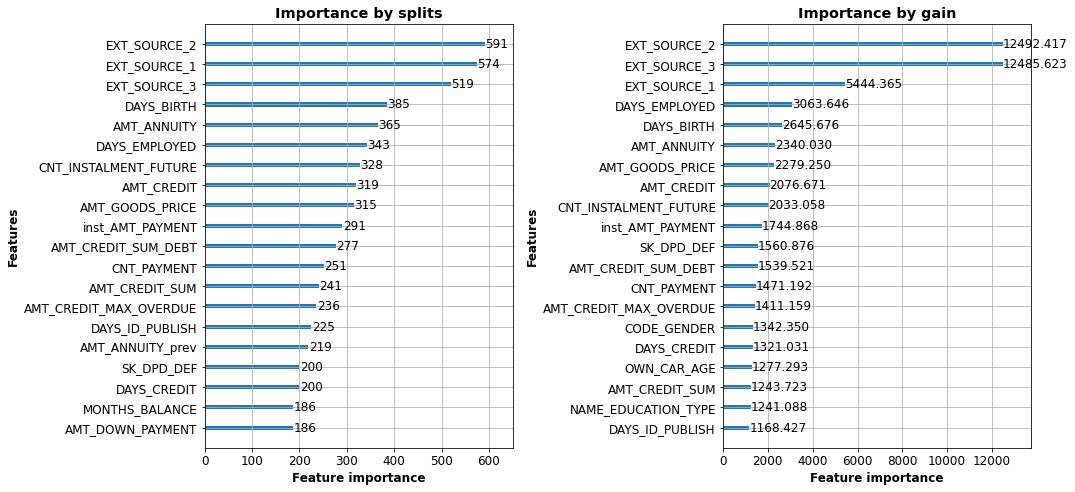

In [82]:
%%time
evals_result = {}
""" Predict on test set """
clf = lgbm.train(train_set=lgbm_train,
                 params=lgbm_params,
#                  valid_sets=[lgbm_train, lgbm_valid],
#                  evals_result=evals_result,
#                  verbose_eval=50,
                 feval=eval_fonct,
                   fobj = obj_fonct,
                 num_boost_round=optimum_boost_rounds)

# clf.params['objective'] = 'probability'
contrib = clf.predict(X_test, pred_contrib =True)
# Pour une raison que j'ignore, quand je renseigne obj_fonct, on a le même résultat pour clf.predict(X_test, raw_score = True)
# et clf.predict(X_test, raw_score = False) qui est la valeur par défaut
# le parametre objective : binary a disparu dans clf.params alors qu'il est bien dans lgbm_params, mais il ne disparait pas 
# s'il n'y a pas de fonction objectif (fobj)
# le raw score est le score "brut", par exemple une note de 19 mais on ne sait pas si c'est sur 20 ou sur 100
# Ici, c'est donc le score avant la sigmoid.
# Donc pour que ce soit clair, je fais la prédiction avec raw_score = True et ensuite je fais une sigmoide
# Je ne sais pas si celle que j'avais mise dans la validation croisée est prise en compte. Je pense que cela n'a pas 
# d'importance pûiqu'on choisit le seuil ensuite
y_raw = clf.predict(X_test, raw_score = True)
y_pred = 1/(1+np.exp(-y_raw))

fig, (ax, ax1) = plt.subplots(1, 2, figsize=[15, 7])
# doc sur les paramètres de lgbm.plot_importance
# importance_type (string, optional (default="split")) – How the importance is calculated. 
# If “split”, result contains numbers of times the feature is used in a model. 
# If “gain”, result contains total gains of splits which use the feature.
lgbm.plot_importance(clf, ax=ax, max_num_features=20, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=20, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()
# plt.savefig('feature_importance.png')

In [83]:
y_raw

array([-0.30250043, -1.66674363, -0.95826914, ..., -1.19156649,
       -1.01209262, -2.32597104])

In [84]:
clf.predict(X_test, raw_score = False)

array([-0.30250043, -1.66674363, -0.95826914, ..., -1.19156649,
       -1.01209262, -2.32597104])

In [85]:
len(y_pred)

101479

In [86]:
(clf.predict(X_test, raw_score=False)==clf.predict(X_test, raw_score=True)).sum()

101479

In [87]:
clf.params

{'boosting': 'dart',
 'learning_rate': 0.1,
 'min_data_in_leaf': 30,
 'num_leaves': 31,
 'max_depth': -1,
 'feature_fraction': 0.5,
 'scale_pos_weight': 1.4,
 'drop_rate': 0.025,
 'reg_lambda': 14,
 'sigmoid': 0.3,
 'objective': 'none'}

In [88]:
lgbm_params

{'boosting': 'dart',
 'application': 'binary',
 'objective': 'binary',
 'learning_rate': 0.1,
 'min_data_in_leaf': 30,
 'num_leaves': 31,
 'max_depth': -1,
 'feature_fraction': 0.5,
 'scale_pos_weight': 1.4,
 'drop_rate': 0.025,
 'reg_lambda': 14,
 'sigmoid': 0.3}

In [89]:
# clf.params['objective'] = 'binary'
# clf.params['objective'] = 'probability'

# https://github.com/slundberg/shap/issues/1042
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


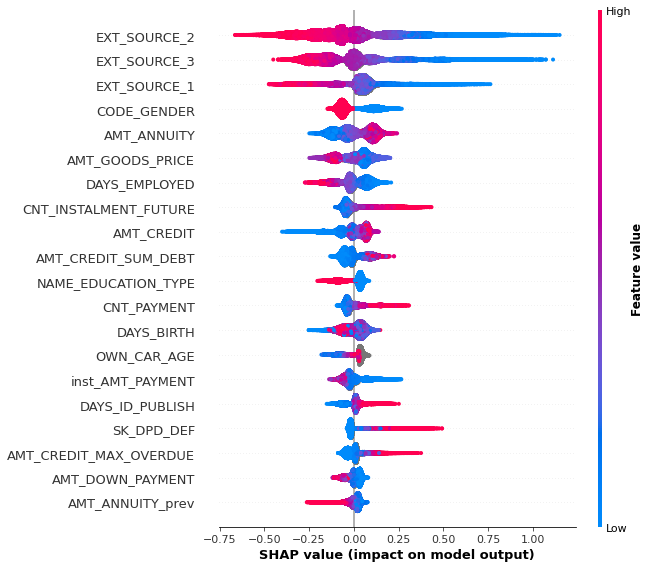

In [90]:
shap.summary_plot(shap_values, X_test)

In [91]:
len(shap_values)

101479

In [92]:
base = explainer.expected_value
base

-1.330546924347542

In [93]:
1/(1+np.exp(-base))

0.20906891190367205

In [94]:
np.log(y_test.sum()/(len(y_test)-y_test.sum()))

-2.442523782420533

In [95]:
np.log(y_train.sum()/(len(y_train)-y_train.sum()))

-2.4275721864283883

In [96]:
df_homecredit[df_homecredit["Row"]=="AMT_ANNUITY"]

,Unnamed: 0,Table,Row,Description,Special
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN
138,141,bureau.csv,AMT_ANNUITY,Annuity of the Credit Bureau credit,NaN
176,179,previous_application.csv,AMT_ANNUITY,Annuity of previous application,NaN


In [97]:
df_application_train.loc[df_application_train["TARGET"]==1, "AMT_ANNUITY"].mean()

26481.744290030212

In [98]:
df_application_train.loc[df_application_train["TARGET"]==0, "AMT_ANNUITY"].mean()

27163.62334880463

In [99]:
help(shap.summary_plot)

Help on function summary_plot in module shap.plots.summary:

summary_plot(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', auto_size_plot=None)
    Create a SHAP summary plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names : list
        Names of the features (length # features)
    
    max_display : int
        How many top

infos sur l'utilisation de predict avec pred_contrib=True :  
https://github.com/microsoft/LightGBM/issues/1969

outil pour l'interprétation : SHAP  
https://github.com/slundberg/shap

In [100]:
y_pred.shape

(101479,)

In [101]:
contrib.shape

(101479, 375)

In [102]:
y_pred.mean()

0.23196148197635205

In [103]:
contrib[:,:-1].mean()

-9.151493482534084e-07

In [104]:
np.unique(contrib[:,-1])

array([-1.33054692])

In [105]:
y_pred[:10]

array([0.42494635, 0.15885882, 0.27722488, 0.15904741, 0.20761473,
       0.43951823, 0.15890678, 0.29188635, 0.24079922, 0.17028939])

In [106]:
data.shape

(307511, 374)

## Calcul du seuil


Nous travaillons pour un organisme de crédit. Nous voulons donc minimiser le risque que le crédit ne soit pas remboursé. Nous voulons donc minimiser le nombre de faux négatifs, c'est à dire les personnes auxquelles on accorderait un crédit et qui ne seraient pas en mesure de le rembourser.    

Calculons le seuil correspondant à un taux de faux négatifs (FN/(FN+TP))choisi.  
Pour avoir un taux de faux négatifs < 5%, il faut un taux de vrai positifs (TP/(FN+TP))>95%.

In [107]:
if eval_fonct_str in ["eval_auc", "focal_loss"]:
    fpr, tpr, th = roc_curve(y_test, y_pred)
    fn_max = 0.05
    idx = np.min(np.where(tpr>(1-fn_max)))
#     print(f"Pour un taux de faux négatif de {fn_max*100}%, ")
#     print(f"le taux de faux positifs est de {fpr[idx]*100:.1f}%,")
#     print(f"et le seuil est de {th[idx]*100:.1f}%")
    seuil = th[idx]
    print("seuil : ", seuil)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str in ["eval_average_precision", "precision_recal_auc"]:
    prec, rec, th = precision_recall_curve(y_test, y_pred)
    fn_max = 0.05
    idx = np.max(np.where(rec>(1-fn_max)))
    seuil = th[idx]
    print("seuil : ", seuil)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str in ["eval_Kulczynski_mod"]:
    thresholds = np.arange(0,1, 0.01)
    scores = [eval_fonct_score(y_test, y_pred, t, eval_fonct_param1) for t in thresholds]
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    seuil = thresholds[idx]
    print("seuil : ", seuil)
    print("score : ", score)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str == "eval_perso1":
    thresholds = np.arange(0,1, 0.01)
    scores = [eval_fonct_score(y_test, y_pred, t, eval_fonct_param1, eval_fonct_param2) for t in thresholds]
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    seuil = thresholds[idx]
    print("seuil : ", seuil)
    print("score : ", score)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str == "eval_tanimoto_mod":
    thresholds = np.arange(0,1, 0.01)
    scores = [eval_fonct_score(y_test, y_pred, t) for t in thresholds]
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    seuil = thresholds[idx]
    print("seuil : ", seuil)
    print("score : ", score)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str == "fbeta_eval3_8":
    thresholds = np.arange(0,1, 0.01)
    scores = [eval_fonct_score(y_test, to_labels(y_pred, t), eval_fonct_param1) for t in thresholds]
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    seuil = thresholds[idx]
    print("seuil : ", seuil)
    print("score : ", score)
    conf_matrix(y_test, y_pred, seuil)
   

seuil :  0.14041104785974878
tp :  7712
tn :  27637
fp :  65725
fn :  405
fpr = 70.40%
fnr = 4.99%
precision = 10.50%
recall = 95.01%


In [108]:
(y_pred.min())

0.024520855468518357

In [109]:
(y_test==1).sum()

8117

In [110]:
eval_fonct_str

'precision_recal_auc'

In [111]:
27809+7712

35521

In [112]:
roc_auc_score(y_test, y_pred)

0.7821887906019355

In [113]:
# pd.Series(y_pred).to_csv("y_pred_fbeta3_95.csv", index = False)

**fbeta_score, beta=4**  
tp :  7898  
tn :  16390  
fp :  76972  
fn :  219  
fpr = 82.44%  
fnr = 2.70%  
precision = 9.31%  
recall = 97.30%  

**fbeta_score, beta=3.8**  
seuil :  0.05  
score :  0.6207372298025252  
tp :  7602  
tn :  29084  
fp :  64278  
fn :  515  
fpr = 68.85%  
fnr = 6.34%  
precision = 10.58%  
recall = 93.66%  

**fbeta_score, beta=3.6**  
seuil :  0.06  
score :  0.6108316344692227  
tp :  7331  
tn :  38346  
fp :  55016  
fn :  786  
fpr = 58.93%  
fnr = 9.68%  
precision = 11.76%  
recall = 90.32%  

**fbeta_score, beta=3**   
tp :  6876  
tn :  48479  
fp :  44883  
fn :  1241  
fpr = 48.07%  
fnr = 15.29%  
precision = 13.28%  
recall = 84.71%  

**fbeta_score, beta=3, 1000 rounds**   
seuil :  0.07  
score :  0.557031555613509  
tp :  6835  
tn :  50546  
fp :  42816  
fn :  1282  
fpr = 45.86%  
fnr = 15.79%  
precision = 13.77%  
recall = 84.21%  

**fbeta_score, beta = 2**    
tp :  5502  
tn :  68102  
fp :  25260  
fn :  2615  
fpr = 27.06%  
fnr = 32.22%  
precision = 17.89%  
recall = 67.78%  

**AUC**    
tp : 7712  
tn : 27154  
fp : 66208  
fn : 405  
fpr : 0.7091536171033183  
fnr : 0.04989528150794629  
precision : 0.10432900432900433  
recall : 0.9501047184920537  


**average_precision**  
seuil :  0.07509545445933284  
tp :  7712  
tn :  25559  
fp :  67803  
fn :  405  
fpr = 72.62%  
fnr = 4.99%  
precision = 10.21%  
recall = 95.01%   

**balanced_accuracy_score**    
tp :  5374  
tn :  69599  
fp :  23763  
fn :  2743  
fpr = 25.45%  
fnr = 33.79%  
precision = 18.44%  
recall = 66.21%  

**Matthews**  
tp :  5146  
tn :  71592  
fp :  21770  
fn :  2971  
fpr = 23.32%  
fnr = 36.60%  
precision = 19.12%  
recall = 63.40%  

**tanimoto_mod**    
seuil :  0.41000000000000003  
score :  0.750621228257011  
tp :  1103  
tn :  91935  
fp :  1427  
fn :  7014  
fpr = 1.53%  
fnr = 86.41%  
precision = 43.60%  
recall = 13.59%  

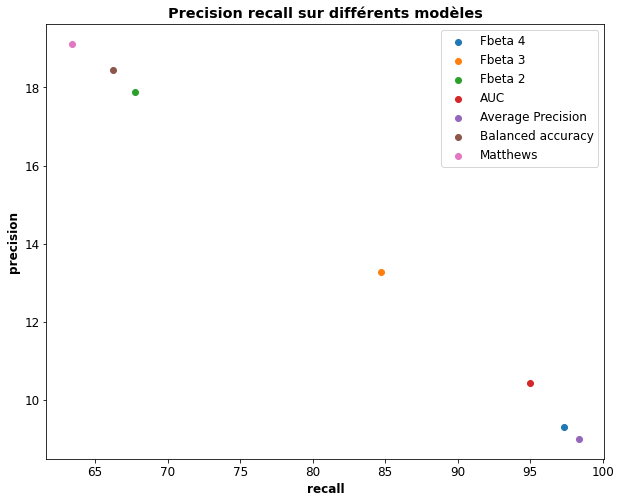

In [114]:
plt.scatter(y=9.31, x=97.3, label="Fbeta 4")
plt.scatter(y=13.28, x=84.71, label="Fbeta 3")
plt.scatter(y=17.89, x=67.78, label="Fbeta 2")
plt.scatter(y=10.43, x=95, label="AUC")
plt.scatter(y=9, x=98.36, label="Average Precision")
plt.scatter(y=18.44, x=66.21, label="Balanced accuracy")
plt.scatter(y=19.12, x=63.40, label="Matthews")
plt.legend()
plt.title("Precision recall sur différents modèles")
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()


In [115]:
# prec, rec, th = precision_recall_curve(y_test, y_pred)
# plt.plot(rec, prec)
# plt.xlabel("recall")
# plt.ylabel("precision")
# plt.title("optimisation de Average Precision")
# plt.show()

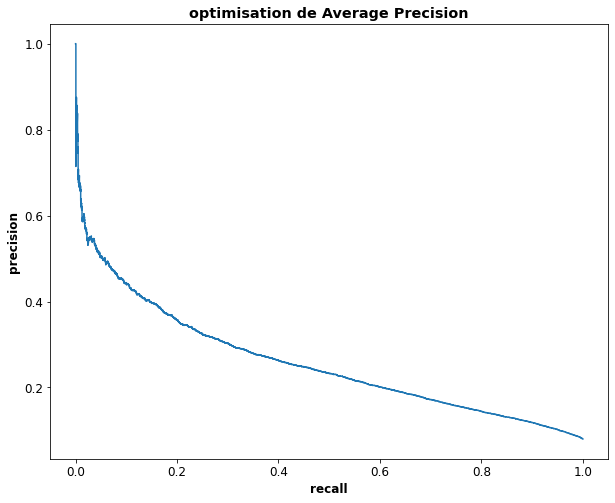

# Explicabilité

## Calcul des coefficients de contribution au résultat

### Par le modèle

In [116]:
%%time
y_pred = clf.predict(data)
contrib = clf.predict(data, pred_contrib =True)
y_pred_raw = clf.predict(data, raw_score=True)
y_pred

Wall time: 2min 24s


array([ 0.36229788, -2.24540602, -1.74624938, ..., -1.21681811,
       -0.8490166 , -0.84206316])

In [117]:
contrib

array([[ 7.02885465e-03,  6.27843533e-02,  9.19957308e-03, ...,
        -9.45443697e-04, -3.01432094e-02, -1.33054692e+00],
       [ 9.90320328e-03, -5.85814844e-02,  5.14579383e-03, ...,
        -7.43861412e-03, -6.07623754e-02, -1.33054692e+00],
       [-4.66196824e-02,  1.58611894e-01, -1.86358652e-02, ...,
         7.22353954e-03,  9.86430864e-03, -1.33054692e+00],
       ...,
       [ 1.11782093e-02, -7.46663600e-02,  6.50409613e-03, ...,
         1.78114328e-02,  6.48821493e-02, -1.33054692e+00],
       [ 9.41616673e-03, -4.64836689e-02,  7.68518948e-03, ...,
         6.45371782e-03, -3.66674263e-03, -1.33054692e+00],
       [ 1.04371104e-02, -6.06803484e-02,  3.96523354e-03, ...,
        -3.37719084e-03, -5.06153123e-02, -1.33054692e+00]])

In [118]:
contrib[:,-1]

array([-1.33054692, -1.33054692, -1.33054692, ..., -1.33054692,
       -1.33054692, -1.33054692])

In [119]:
y_pred_raw

array([ 0.36229788, -2.24540602, -1.74624938, ..., -1.21681811,
       -0.8490166 , -0.84206316])

### En utilisant les shap_values

In [120]:
#clf.params['objective'] = 'probability'
# https://github.com/slundberg/shap/issues/1042

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(data)
df_shap_values = pd.DataFrame(data=shap_values, columns = data.columns)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


**NB : les shap values sont aussi données par le tableau contrib calculé plus haut**  
contrib contient en plus la base value dans sa dernière colonne

In [121]:
shap_values

array([[ 0.00702885,  0.06278435,  0.00919957, ..., -0.00224912,
        -0.00094544, -0.03014321],
       [ 0.0099032 , -0.05858148,  0.00514579, ..., -0.00064935,
        -0.00743861, -0.06076238],
       [-0.04661968,  0.15861189, -0.01863587, ...,  0.00037029,
         0.00722354,  0.00986431],
       ...,
       [ 0.01117821, -0.07466636,  0.0065041 , ...,  0.01570092,
         0.01781143,  0.06488215],
       [ 0.00941617, -0.04648367,  0.00768519, ...,  0.00908755,
         0.00645372, -0.00366674],
       [ 0.01043711, -0.06068035,  0.00396523, ..., -0.00348749,
        -0.00337719, -0.05061531]])

## Préparation des données

Pour l'explicabilité, nous allons utiliser deux dataframe qui ici seront confondus.  
**df_data_true** correspond aux données d'entrainement. C'est ce jeu de données qui permet d'obtenir les valeurs de reférence quand on compare un demandeur à l'ensemble de la population. Il est utilisé dans le tableau de bord pour l'explicabilité.  
**df_data_applicant** correspond aux données des utilisateurs actuels. Ici c'est le même que df_data_true (sauf qu'on utilise le score prédit et non une valeur à 0 ou 1), mais dans la vie de l'application, ces données seront différentes.

### Aggrégation des données

In [122]:
df_data_applicant = pd.concat([applicants, pd.Series(y_pred, name="score"), data], axis=1)
df_data_applicant

,SK_ID_CURR,score,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,100002,0.362298,0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003,-2.245406,0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,100004,-1.746249,1,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006,-1.859406,0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,100007,-1.171604,0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,-0.844552,0,0,0,1,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,1.142857,4.000000,-120.000000,-156.285714,7492.924286,7492.924286
307507,456252,-0.520884,0,1,0,0,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500
307508,456253,-1.216818,0,1,0,0,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,1.000000,4.785714,-2372.928571,-2387.428571,4399.707857,4115.915357
307509,456254,-0.849017,0,1,0,0,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,1.000000,5.263158,-142.263158,-161.263158,10239.832895,10239.832895


In [123]:
df_data_true = pd.concat([applicants, df_data_true], axis=1)
df_data_true

,SK_ID_CURR,risk,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,100002,1,0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003,0,0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,100004,0,1,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006,0,0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,100007,0,0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,1,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,1.142857,4.000000,-120.000000,-156.285714,7492.924286,7492.924286
307507,456252,0,0,1,0,0,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500
307508,456253,0,0,1,0,0,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,1.000000,4.785714,-2372.928571,-2387.428571,4399.707857,4115.915357
307509,456254,1,0,1,0,0,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,1.000000,5.263158,-142.263158,-161.263158,10239.832895,10239.832895


In [124]:
feature_gain = pd.concat([pd.Series(clf.feature_name(), name="feature"),
    pd.Series(clf.feature_importance(importance_type='gain'), name="gain")], axis=1)
feature_gain.sort_values(by="gain", ascending=False).head(20)

,feature,gain
40,EXT_SOURCE_2,12492.417333
41,EXT_SOURCE_3,12485.623012
39,EXT_SOURCE_1,5444.365255
16,DAYS_EMPLOYED,3063.645950
15,DAYS_BIRTH,2645.675795
7,AMT_ANNUITY,2340.030229
8,AMT_GOODS_PRICE,2279.250281
6,AMT_CREDIT,2076.671429
329,CNT_INSTALMENT_FUTURE,2033.057720
373,inst_AMT_PAYMENT,1744.868489


In [125]:
(feature_gain["gain"]==0.).sum()

104

### Modification de certaines données

**DAYS_BIRTH**  
Nous calculons l'âge en année à la place.

In [126]:
df_data_applicant["DAYS_BIRTH"] = round(df_data_applicant["DAYS_BIRTH"]/365)
df_data_true["DAYS_BIRTH"] = round(df_data_true["DAYS_BIRTH"]/365)

In [127]:
df_data_applicant["DAYS_BIRTH"].describe()

count    307511.000000
mean         43.938646
std          11.964047
min          21.000000
25%          34.000000
50%          43.000000
75%          54.000000
max          69.000000
Name: DAYS_BIRTH, dtype: float64

**Variables catégorielles issues de la table df_application_train**

In [128]:
unfactorize(df_data_applicant, indexers)

In [129]:
unfactorize(df_data_true, indexers)

In [130]:
df_data_true

,SK_ID_CURR,risk,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,1.142857,4.000000,-120.000000,-156.285714,7492.924286,7492.924286
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,1.000000,4.785714,-2372.928571,-2387.428571,4399.707857,4115.915357
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,1.000000,5.263158,-142.263158,-161.263158,10239.832895,10239.832895


## Analyse d'une demande

In [131]:
np.random.seed(42)

In [132]:
this_client = np.random.randint(0, len(y))
this_client

121958

### Description du client

In [133]:
no_client = df_data_applicant.loc[this_client, "SK_ID_CURR"]
print("numéro de client : ", no_client)
genre = df_data_applicant.loc[this_client, "CODE_GENDER"]
if genre==0:
    print("genre : masculin")
else :
    print("genre : féminin")
age = df_data_applicant.loc[this_client, "DAYS_BIRTH"]
print(f"âge : {age:.0f} ans")

numéro de client :  241394
genre : féminin
âge : 36 ans


In [134]:
age

36.0

In [135]:
df_homecredit[df_homecredit["Row"]=="CNT_INSTALMENT"]

,Unnamed: 0,Table,Row,Description,Special
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN


In [136]:
list(df_homecredit[df_homecredit["Row"]=="AMT_GOODS_PRICE"]["Description"])

['For consumer loans it is the price of the goods for which the loan is given',
 'Goods price of good that client asked for (if applicable) on the previous application']

In [137]:
# df_application_train["AMT_ANNUITY"].describe()
df_pos_cash_balance["CNT_INSTALMENT_FUTURE"].describe()

count    9.975271e+06
mean     1.048384e+01
std      1.110906e+01
min      0.000000e+00
25%      3.000000e+00
50%      7.000000e+00
75%      1.400000e+01
max      8.500000e+01
Name: CNT_INSTALMENT_FUTURE, dtype: float64

In [138]:
df_prev_app.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

### Score et interprétation

In [139]:
score = df_data_applicant.loc[this_client, "score"]
print("Score : " + f"{score*100:.1f} %")
if score < seuil :
    print("==> pas de risque particulier")
else :
    print("==> client à risque")
score_ext_1, score_ext_2, score_ext_3 = df_data_applicant.loc[this_client, ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]]
print(f"Scores externes : score 1 : {score_ext_1*100:.0f}%, score 2 : {score_ext_2*100:.0f}%, score 3 : {score_ext_3*100:.0f}%")
annuity = df_data_applicant.loc[this_client, "AMT_ANNUITY"]
print(f"Montant de l'annuité : {annuity:.2f}")
goods_price = df_data_applicant.loc[this_client, "AMT_GOODS_PRICE"]
print(f"Prix du bien acheté : {goods_price}")
installment_prev_credit = df_data_applicant.loc[this_client, "CNT_INSTALMENT_FUTURE"]
print(f"Nombre de versements restants de précédents crédits : {installment_prev_credit}")

Score : -45.0 %
==> pas de risque particulier
Scores externes : score 1 : 35%, score 2 : 41%, score 3 : 28%
Montant de l'annuité : 35239.50
Prix du bien acheté : 630000.0
Nombre de versements restants de précédents crédits : 8.4


In [140]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[this_client,:], data.iloc[this_client,:])
# shap.force_plot(explainer.expected_value[1], shap_values[1][this_client,:], data.iloc[this_client,:], link="logit")
# shap.visualize(shap_values[this_client,:], data.iloc[this_client,:], link=shap.LogitLink())

In [141]:
shap_values[this_client,:].sum()+explainer.expected_value

-0.44973469569324587

In [142]:
shap_values.mean()

-3.020003860397561e-07

On a donc,  (somme des shap values de l'individu) + (base value) = model output value  
soit (somme des contributions des features) + (valeur de base) = valeur de l'individu

In [143]:
# https://www.kaggle.com/dansbecker/shap-values
# https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d
# https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

### Comparaison à des clients semblables

In [144]:
facteurs_favorables = df_shap_values.iloc[this_client, :].sort_values().head().keys()
facteurs_favorables

Index(['OWN_CAR_AGE', 'NAME_EDUCATION_TYPE', 'AMT_CREDIT_SUM_DEBT',
       'inst_AMT_PAYMENT', 'DAYS_ID_PUBLISH'],
      dtype='object')

In [145]:
facteurs_risque = df_shap_values.iloc[this_client, :].sort_values().tail().keys()
facteurs_risque

Index(['AMT_CREDIT', 'CODE_GENDER', 'AMT_ANNUITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3'],
      dtype='object')

In [146]:
print("Facteurs favorables : ")
for f in facteurs_favorables :
    print(f, df_data_applicant.loc[this_client, f])

print("\nFacteurs de risque : ")
for f in facteurs_risque :
    print(f, df_data_applicant.loc[this_client, f])

Facteurs favorables : 
OWN_CAR_AGE 3.0
NAME_EDUCATION_TYPE Higher education
AMT_CREDIT_SUM_DEBT 0.0
inst_AMT_PAYMENT 12803.107499999998
DAYS_ID_PUBLISH -4449

Facteurs de risque : 
AMT_CREDIT 729792.0
CODE_GENDER M
AMT_ANNUITY 35239.5
EXT_SOURCE_2 0.4084003044667711
EXT_SOURCE_3 0.2750003523983893


Facteurs favorables : 


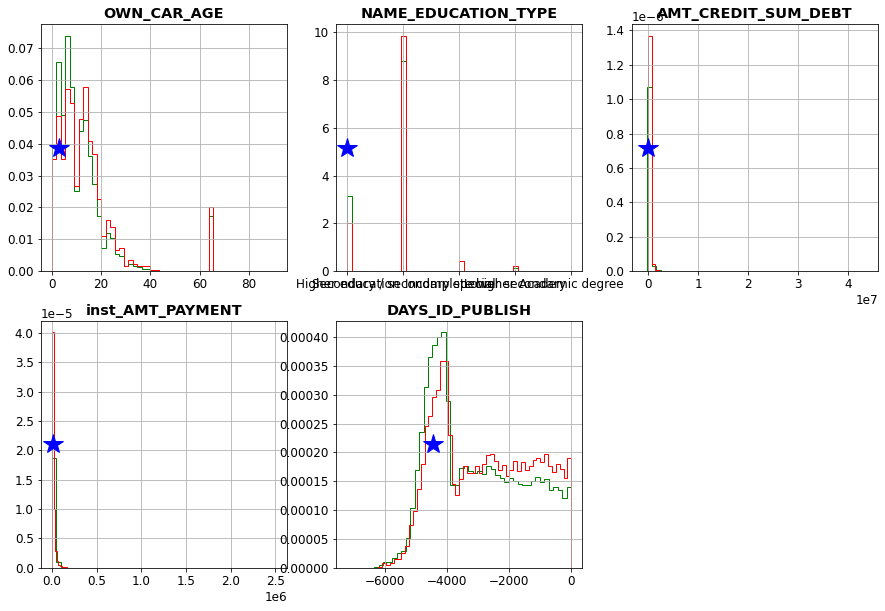


Facteurs de risque : 


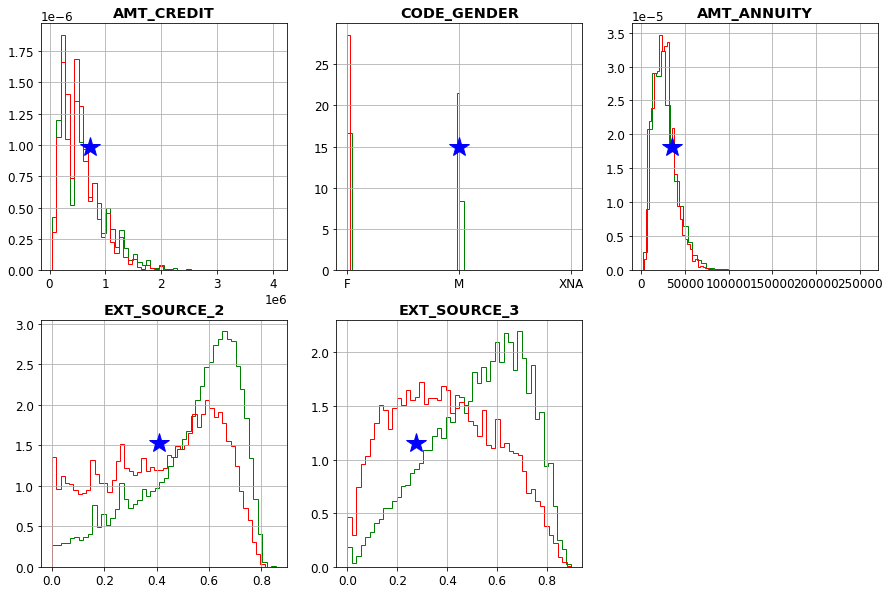

In [147]:
print("Facteurs favorables : ")
plt.figure(figsize=(15,10))
for i, f in enumerate(facteurs_favorables) :
    plt.subplot(2,3, i +1)
#     print(f, df_data_applicant.loc[this_client, f])
# #     print(f, df_data_true.loc[df_data_true["risk"]==0, f].mean())
#     print(f, df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.25))
#     print(f, df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.75))
    nf = df_data_true.loc[df_data_true["risk"]==0, f].hist(density=True, bins=50, histtype='step', color="green")
    nr = df_data_true.loc[df_data_true["risk"]==1, f].hist(density=True, bins=50, histtype='step', color="red")
    y_plot = max(nf.get_ylim()[1], nr.get_ylim()[1])/2
    plt.plot(df_data_applicant.loc[this_client, f], y_plot, color="blue", marker="*", markersize=20)    
    plt.title(f)
plt.show()
    
    
print("\nFacteurs de risque : ")
plt.figure(figsize=(15,10))
for i, f in enumerate(facteurs_risque) :
    plt.subplot(2,3, i +1)
#     print(f, df_data_applicant.loc[this_client, f])
# #     print(f, df_data_true.loc[df_data_true["risk"]==0, f].mean())
#     print(f, df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.25))
#     print(f, df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.75))
    nf = df_data_true.loc[df_data_true["risk"]==0, f].hist(density=True, bins=50, histtype='step', color="green")
    nr = df_data_true.loc[df_data_true["risk"]==1, f].hist(density=True, bins=50, histtype='step', color="red")
    y_plot = max(nf.get_ylim()[1], nr.get_ylim()[1])/2
    plt.plot(df_data_applicant.loc[this_client, f], y_plot, color="blue", marker="*", markersize=20)    
    plt.title(f)

plt.show()


In [148]:
seuil

0.14041104785974878

Facteurs favorables : 


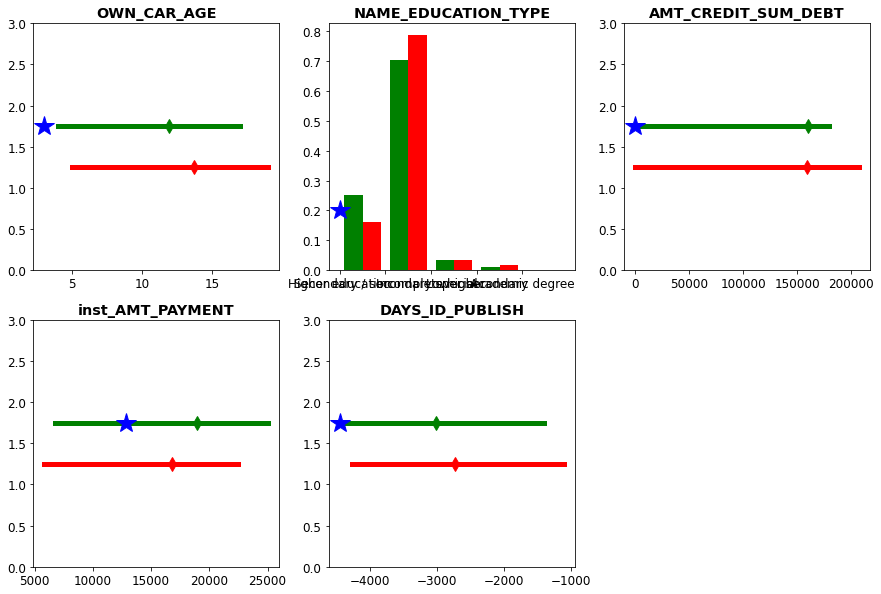


Facteurs de risque : 


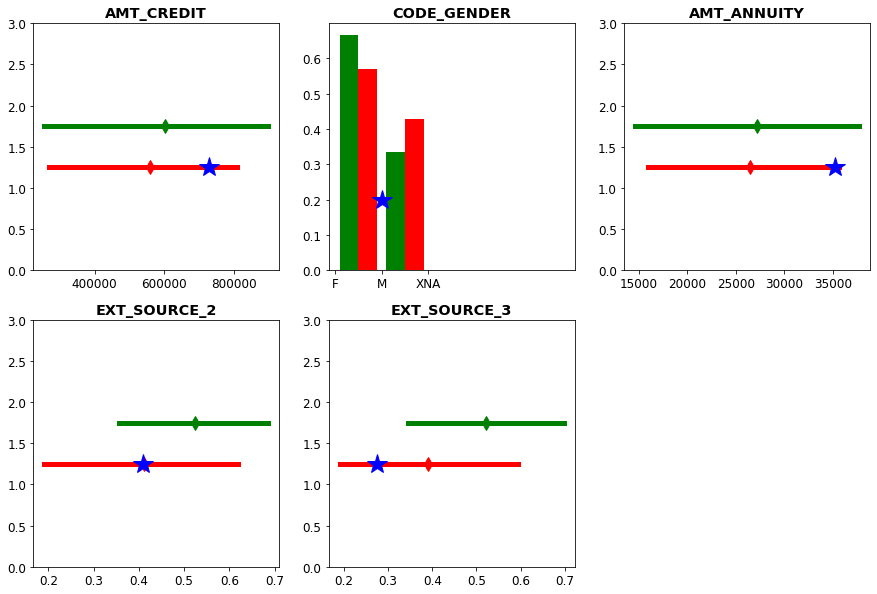

In [149]:
yplot_risque = 1.25
yplot_favorable = 1.75
# if score < seuil:
#     this_client_yplot = yplot_favorable
# else :
#     this_client_yplot = yplot_risque

    
print("Facteurs favorables : ")
plt.figure(figsize=(15,10))
for i, f in enumerate(facteurs_favorables) :
    ax = plt.subplot(2,3, i +1)
    if df_data_true[f].dtype =="object":
#         print(f)
        a, b, c = plt.hist((df_data_true.loc[df_data_true["risk"]==0, f],
            df_data_true.loc[df_data_true["risk"]==1, f]), color=["green", "red"], density=True, bins=range(6))
        plt.plot(df_data_applicant.loc[this_client, f], (a[0].mean()+a[1].mean())/2, color="blue", marker="*", markersize=20)    
    else:
        qf10 = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.2)
        qf90 = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.8)
        fm = df_data_true.loc[df_data_true["risk"]==0, f].mean()
        qr10 = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.2)
        qr90 = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.8)
        rm = df_data_true.loc[df_data_true["risk"]==1, f].mean()
        plt.plot((qf10, qf90), (yplot_favorable,yplot_favorable), linewidth=5, color="green")
        plt.plot(fm, yplot_favorable, color="green", marker="d", markersize=10)    
        plt.plot((qr10, qr90), (yplot_risque,yplot_risque), linewidth=5, color="red")
        plt.plot(rm, yplot_risque, color="red", marker="d", markersize=10)    
        ax.set_ylim(0,3)
        plt.plot(df_data_applicant.loc[this_client, f], yplot_favorable, color="blue", marker="*", markersize=20)    
    plt.title(f)
plt.show()
    
    
print("\nFacteurs de risque : ")
plt.figure(figsize=(15,10))
for i, f in enumerate(facteurs_risque) :
    ax = plt.subplot(2,3, i +1)
    if df_data_true[f].dtype =="object":
#         print(f)
        a, b, c = plt.hist((df_data_true.loc[df_data_true["risk"]==0, f],
            df_data_true.loc[df_data_true["risk"]==1, f]), color=["green", "red"], density=True, bins=range(6))
        plt.plot(df_data_applicant.loc[this_client, f], (a[0].mean()+a[1].mean())/2, color="blue", marker="*", markersize=20)    
    else:
        qf10 = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.2)
        qf90 = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.8)
        fm = df_data_true.loc[df_data_true["risk"]==0, f].mean()
        qr10 = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.2)
        qr90 = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.8)
        rm = df_data_true.loc[df_data_true["risk"]==1, f].mean()
        plt.plot((qf10, qf90), (yplot_favorable,yplot_favorable), linewidth=5, color="green")
        plt.plot(fm, yplot_favorable, color="green", marker="d", markersize=10)    
        plt.plot((qr10, qr90), (yplot_risque,yplot_risque), linewidth=5, color="red")
        plt.plot(rm, yplot_risque, color="red", marker="d", markersize=10)    
        plt.plot(df_data_applicant.loc[this_client, f], yplot_risque, color="blue", marker="*", markersize=20)    
        ax.set_ylim(0,3)
    plt.title(f)
plt.show()


NAME_EDUCATION_TYPE


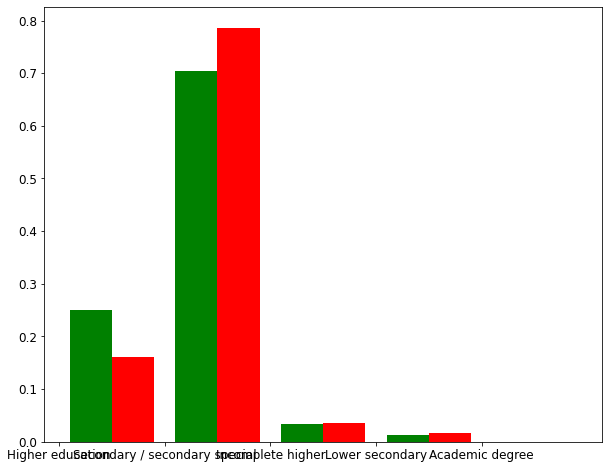

In [150]:
for i, f in enumerate(facteurs_favorables) :
    if df_data_true[f].dtype =="object":
        print(f)
        a, b, c = plt.hist((df_data_true.loc[df_data_true["risk"]==0, f],
        df_data_true.loc[df_data_true["risk"]==1, f]), color=["green", "red"], density=True, bins=range(6))

In [151]:
print(a)
print(b)
print(c)

[[2.50645593e-01 7.03490799e-01 3.32701301e-02 1.20239418e-02
  5.69536518e-04]
 [1.61490433e-01 7.86465257e-01 3.51258812e-02 1.67975831e-02
  1.20845921e-04]]
[0 1 2 3 4 5]
<a list of 2 Lists of Patches objects>


In [152]:
a

array([[2.50645593e-01, 7.03490799e-01, 3.32701301e-02, 1.20239418e-02,
        5.69536518e-04],
       [1.61490433e-01, 7.86465257e-01, 3.51258812e-02, 1.67975831e-02,
        1.20845921e-04]])

In [153]:
f="NAME_EDUCATION_TYPE"
nb_0 = df_data_true[(df_data_true["risk"]==0)].shape[0]
nb_1 = df_data_true[(df_data_true["risk"]==1)].shape[0]
x=[]
y0=[]
y1=[]
valeurs = df_data_true[f].unique()
for v in valeurs:
    x.append(v)
    r = df_data_true[(df_data_true["risk"]==0) & (df_data_true[f]==v)].shape[0]/nb_0
    y0.append(r)
    r = df_data_true[(df_data_true["risk"]==1) & (df_data_true[f]==v)].shape[0]/nb_1
    y1.append(r)
print(x)
print(y0)
print(y1)

['Secondary / secondary special', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Academic degree']
[0.7034907989783717, 0.2506455926363527, 0.03327013010902556, 0.012023941758700467, 0.0005695365175495072]
[0.7864652567975831, 0.16149043303121852, 0.03512588116817724, 0.016797583081570998, 0.00012084592145015106]


In [154]:
df_data_true[(df_data_true["risk"]==0) & (df_data_true["NAME_EDUCATION_TYPE"]=="Secondary / secondary special")].shape[0]

198867

In [155]:
df_data_true[(df_data_true["risk"]==0)].shape[0]

282686

In [156]:
198867/282686

0.7034907989783717

In [157]:
valeurs

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

# Préparation des données pour API

## Données de référence
Pour chaque colonne, nous calculons un percentile bas (ex 0.2) et un percentile haut(ex 0.8) ainsi que la moyenne. Et cela en séparant les personnes qui ont eu un problème de paiement de celles qui n'en ont pas eu.

In [158]:
df_data_true

,SK_ID_CURR,risk,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,1.142857,4.000000,-120.000000,-156.285714,7492.924286,7492.924286
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,1.000000,4.785714,-2372.928571,-2387.428571,4399.707857,4115.915357
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,1.000000,5.263158,-142.263158,-161.263158,10239.832895,10239.832895


In [159]:
%%time
nb_0 = df_data_true[(df_data_true["risk"]==0)].shape[0]
nb_1 = df_data_true[(df_data_true["risk"]==1)].shape[0]
ref = {}

for f in df_data_true.columns[1:] :
    if df_data_true[f].dtype == "object": # variables catégorielles
        x=[]
        y0=[]
        y1=[]
        valeurs = df_data_true[f].unique()
        for v in valeurs:
            x.append(v)
            r = df_data_true[(df_data_true["risk"]==0) & (df_data_true[f]==v)].shape[0]/nb_0
            y0.append(r)
            r = df_data_true[(df_data_true["risk"]==1) & (df_data_true[f]==v)].shape[0]/nb_1
            y1.append(r)   
        ref[f] = {"type":"qual", "x":x, "y0":y0, "y1":y1}
    else : #variables numériques
        # cas favorable
        fqb = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.2) #favorable, quantile bas
        fqh = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.8) #favorable, quantile haut
        fm = df_data_true.loc[df_data_true["risk"]==0, f].mean() #favorable, moyenne
        # cas à risque
        rqb = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.2) #risque, quantile bas
        rqh = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.8) #risque, quantile haut
        rm = df_data_true.loc[df_data_true["risk"]==1, f].mean() #risque, moyenne
        ref[f] = {"type":"quant", "fqb": fqb, "fqh":fqh, "fm":fm, "rqb": rqb, "rqh": rqh, "rm": rm}


Wall time: 19.9 s


In [160]:
ref

{'risk': {'type': 'quant',
  'fqb': 0.0,
  'fqh': 0.0,
  'fm': 0.0,
  'rqb': 1.0,
  'rqh': 1.0,
  'rm': 1.0},
 'NAME_CONTRACT_TYPE': {'type': 'qual',
  'x': ['Cash loans', 'Revolving loans'],
  'y0': [0.9020998563777477, 0.09790014362225224],
  'y1': [0.9353877139979859, 0.0646122860020141]},
 'CODE_GENDER': {'type': 'qual',
  'x': ['M', 'F', 'XNA'],
  'y0': [0.33395357393008496, 0.6660322760943237, 1.4149975591292105e-05],
  'y1': [0.42920443101711986, 0.5707955689828802, 0.0]},
 'FLAG_OWN_CAR': {'type': 'qual',
  'x': ['N', 'Y'],
  'y0': [0.6568241794782904, 0.3431758205217096],
  'y1': [0.6948237663645519, 0.30517623363544816]},
 'FLAG_OWN_REALTY': {'type': 'qual',
  'x': ['Y', 'N'],
  'y0': [0.694512639465697, 0.3054873605343031],
  'y1': [0.6841087613293051, 0.31589123867069485]},
 'CNT_CHILDREN': {'type': 'quant',
  'fqb': 0.0,
  'fqh': 1.0,
  'fm': 0.41294581266847313,
  'rqb': 0.0,
  'rqh': 1.0,
  'rm': 0.46380664652567977},
 'AMT_INCOME_TOTAL': {'type': 'quant',
  'fqb': 99000

In [161]:
# with open('../dashboard/data/ref.json', 'w') as outfile:
#     json.dump(ref, outfile)

## Données client
Le volume de données étant trop important pour l'hébergement que nous avons pour le dashboard, nous prenons des données réduites.

### Sélection d'un sous-ensemble de données

In [162]:
TAILLE_RED = 1_000
df_data_applicant_red = df_data_applicant[:TAILLE_RED]
df_shap_values_red = pd.concat([applicants,df_shap_values], axis=1)[:TAILLE_RED]

In [163]:
df_data_applicant_red.set_index("SK_ID_CURR", inplace=True)
df_shap_values_red.set_index("SK_ID_CURR", inplace=True)

In [164]:
df_data_applicant_red

,score,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.362298,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
100003,-2.245406,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
100004,-1.746249,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
100006,-1.859406,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
100007,-1.171604,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101152,-1.894941,Cash loans,F,N,N,0,112500.0,495985.5,17946.0,409500.0,...,0.0,0.0,0.0,0.0,1.062500,7.041667,-578.020833,-586.916667,22838.667187,22995.862500
101153,-1.110622,Cash loans,F,N,Y,0,225000.0,1113840.0,57001.5,900000.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-466.000000,-478.333333,15990.870000,15990.870000
101154,-1.881448,Cash loans,F,Y,Y,0,144000.0,517536.0,28206.0,432000.0,...,NaN,NaN,NaN,NaN,1.000000,5.741935,-1264.774194,-1276.451613,6163.821290,6163.821290


In [165]:
df_shap_values_red

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.007029,0.062784,0.009200,0.001320,0.0,-0.000529,0.012230,-0.005467,0.121331,0.000462,...,0.0,0.0,0.0,0.000038,-0.000816,-0.021400,0.000462,-0.002249,-0.000945,-0.030143
100003,0.009903,-0.058581,0.005146,-0.008645,0.0,-0.017846,0.085313,0.081627,-0.110279,-0.001636,...,0.0,0.0,0.0,0.000015,-0.001231,0.010022,-0.000606,-0.000649,-0.007439,-0.060762
100004,-0.046620,0.158612,-0.018636,0.001896,0.0,0.026072,-0.139528,-0.130065,0.040462,0.000012,...,0.0,0.0,0.0,0.000038,-0.012570,0.022230,0.003787,0.000370,0.007224,0.009864
100006,0.006698,-0.102241,0.005049,0.003065,0.0,-0.001652,-0.056054,0.088427,0.061997,0.000174,...,0.0,0.0,0.0,-0.000063,0.000658,0.024182,-0.006579,0.002676,0.000511,-0.084195
100007,0.005712,0.173281,0.018609,0.000499,0.0,-0.000675,-0.009185,-0.049856,-0.047127,0.000199,...,0.0,0.0,0.0,0.000016,-0.007270,-0.001258,0.000344,-0.005951,-0.003305,-0.027511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101152,0.006196,-0.097924,0.003942,-0.004969,0.0,-0.002449,-0.007242,-0.040535,0.069296,-0.000219,...,0.0,0.0,0.0,-0.000071,0.001947,-0.004791,-0.005126,-0.003615,-0.010677,-0.044319
101153,0.009282,-0.048315,0.006506,0.001520,0.0,-0.004330,0.066221,0.128454,-0.082632,0.000080,...,0.0,0.0,0.0,0.000015,-0.007688,0.030221,-0.002755,-0.003923,-0.006531,-0.050341
101154,0.007611,-0.048395,-0.010783,0.000741,0.0,0.001505,0.038317,0.085365,0.115934,0.000256,...,0.0,0.0,0.0,0.000038,0.016043,0.023831,0.001487,0.002295,0.008892,0.065919


In [166]:
# for i in range(5,0,-1):
#     df_data_applicant_red.insert(1, "favorable_" + str(i), np.zeros([TAILLE_RED,1]))
# for i in range(5,0,-1):
#     df_data_applicant_red.insert(1, "risque_" + str(i), np.zeros([TAILLE_RED,1]))

In [167]:
df_data_applicant_red.columns[:15]

Index(['score', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE'],
      dtype='object')

### Transformation en dictionnaire et ajout des critères d'explicabilité

In [168]:
dico_data_applicant_red = df_data_applicant_red.to_dict(orient="index")

In [169]:
%%time
for cl in dico_data_applicant_red.keys():
    facteurs_favorables = df_shap_values_red.loc[cl].sort_values().head(5).keys()
    facteurs_risque = df_shap_values_red.loc[cl].sort_values().tail(5).keys()
    for i in range(5):
        facteur = facteurs_favorables[i]
        fact={}
        fact["name"] = facteur
        fact.update(ref[facteur])
        dico_data_applicant_red[cl].update({"favorable_"+str(i+1):fact})

        facteur = facteurs_risque[i]
        fact={}
        fact["name"] = facteur
        fact.update(ref[facteur])
        dico_data_applicant_red[cl].update({"risque_"+str(i+1):fact})


Wall time: 829 ms


In [170]:
with open('../api/data/clients.json', 'w') as outfile:
    json.dump(dico_data_applicant_red, outfile)

In [171]:
dico_data_applicant_red[100004]

{'score': -1.746249375902108,
 'NAME_CONTRACT_TYPE': 'Revolving loans',
 'CODE_GENDER': 'M',
 'FLAG_OWN_CAR': 'Y',
 'FLAG_OWN_REALTY': 'Y',
 'CNT_CHILDREN': 0,
 'AMT_INCOME_TOTAL': 67500.0,
 'AMT_CREDIT': 135000.0,
 'AMT_ANNUITY': 6750.0,
 'AMT_GOODS_PRICE': 135000.0,
 'NAME_TYPE_SUITE': 'Unaccompanied',
 'NAME_INCOME_TYPE': 'Working',
 'NAME_EDUCATION_TYPE': 'Secondary / secondary special',
 'NAME_FAMILY_STATUS': 'Single / not married',
 'NAME_HOUSING_TYPE': 'House / apartment',
 'REGION_POPULATION_RELATIVE': 0.010032,
 'DAYS_BIRTH': 52.0,
 'DAYS_EMPLOYED': 225.0,
 'DAYS_REGISTRATION': -4260.0,
 'DAYS_ID_PUBLISH': -2531,
 'OWN_CAR_AGE': 26.0,
 'FLAG_MOBIL': 1,
 'FLAG_EMP_PHONE': 1,
 'FLAG_WORK_PHONE': 1,
 'FLAG_CONT_MOBILE': 1,
 'FLAG_PHONE': 1,
 'FLAG_EMAIL': 0,
 'OCCUPATION_TYPE': 'Laborers',
 'CNT_FAM_MEMBERS': 1.0,
 'REGION_RATING_CLIENT': 2,
 'REGION_RATING_CLIENT_W_CITY': 2,
 'WEEKDAY_APPR_PROCESS_START': 'MONDAY',
 'HOUR_APPR_PROCESS_START': 9,
 'REG_REGION_NOT_LIVE_REGION': 0,

### Données pour les histogrammes

In [172]:
df_data_applicant["score"]=df_data_applicant["score"]*100

In [173]:
df_data_applicant

,SK_ID_CURR,score,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,100002,36.229788,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003,-224.540602,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,100004,-174.624938,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006,-185.940565,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,100007,-117.160418,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,-84.455221,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,1.142857,4.000000,-120.000000,-156.285714,7492.924286,7492.924286
307507,456252,-52.088449,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500
307508,456253,-121.681811,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,1.000000,4.785714,-2372.928571,-2387.428571,4399.707857,4115.915357
307509,456254,-84.901660,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,1.000000,5.263158,-142.263158,-161.263158,10239.832895,10239.832895


In [174]:
df_data_applicant[["score", "NAME_CONTRACT_TYPE", "CODE_GENDER", "AMT_INCOME_TOTAL", "NAME_EDUCATION_TYPE"]].to_json(
    "../api/data/histo.json")

In [175]:
df_data_applicant["AMT_INCOME_TOTAL"].max()

117000000.0

In [176]:
df_data_applicant["AMT_INCOME_TOTAL"].quantile(0.9)

270000.0

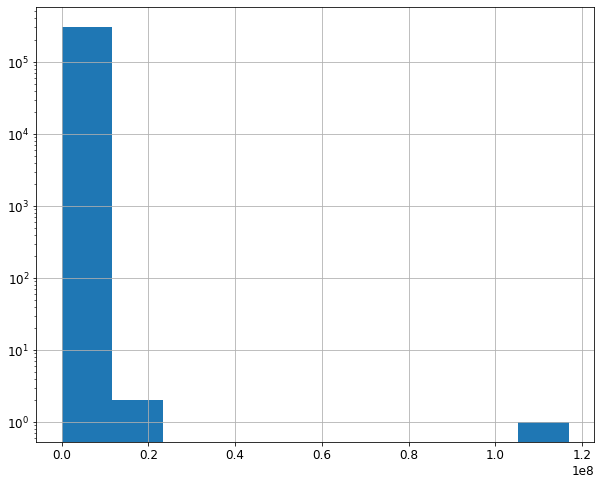

In [177]:
df_data_applicant["AMT_INCOME_TOTAL"].hist(log=True)

In [178]:
df_data_applicant["NAME_EDUCATION_TYPE"].unique()

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)